# Notebook 03 — Career Recommendation Model
## Kenya Career & Skills Intelligence System — Production Pipeline v3.0

### Architecture: Two-Stage Semantic Recommendation Pipeline

| Component | Choice | Reason |
|---|---|---|
| Skill enrichment | **CBC/KCSE implicit skills** | Kenya curriculum context enriches sparse user queries |
| Skill mapping | **Sentence Transformers** `all-MiniLM-L6-v2` | Understands meaning — works for kiswahili, crop rotation, litigation — any skill, any language |
| Career family labels | **SOC code prefix** | Deterministic — no fuzzy match errors like "Security Guards → Technology" |
| Stage 1 Retrieval | **NearestNeighbors (cosine)** | Fast broad recall — top-50 candidates from 894 occupations |
| Stage 2 Ranking | **GradientBoostingClassifier** | Learned optimal weights for skill match, demand, AI risk, zone fit |
| Course matching | **TF-IDF text similarity** | Maps careers to relevant courses across edX, Udemy, Coursera |

### What this version adds over the base notebook
- **Ported 250+ entry skill synonym map** — used to enrich semantic queries with O\*NET terminology
- **22 CBC pathways** mapped to implicit skills (Pure Science, Drama & Theatre, Home Science, etc.)
- **28 KCSE subjects** mapped to implicit skills including all vocational/technical subjects
- **150+ career goal boost keywords** across 15 career families including Kenyan-specific terms
- **Enriched semantic queries** — implicit skills from education background are appended to user queries before embedding, giving the transformer far richer context than raw user input alone
- All 6 user types: CBC, 8-4-4, Graduate, Professional, Postgraduate, Diploma

### Covers ALL 894 O\*NET occupations:
Finance · Healthcare · Education · Technology · Law · Agriculture · Aviation · Arts · Engineering · Hospitality · Science · Transport · Sports · Construction · Social Services · and more

## 1.0 — Setup & Imports

In [1]:
#! pip uninstall keras -y
#! pip install keras==2.11.0

In [2]:
# ── Core libraries ────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
import joblib
import json
import re
from pathlib import Path
from collections import Counter, defaultdict

# ── ML libraries ──────────────────────────────────────────────────────────────
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, ndcg_score
from sklearn.feature_extraction.text import TfidfVectorizer

warnings.filterwarnings('ignore')
np.random.seed(42)

# ── Paths ──────────────────────────────────────────────────────────────────────
PROCESSED_DIR = Path('data/processed')
ARTIFACTS_DIR = Path('artifacts')
MODEL_DIR     = Path('models')
for d in [PROCESSED_DIR, ARTIFACTS_DIR, MODEL_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(' Core imports successful')
print()
print('Checking for sentence-transformers...')
try:
    from sentence_transformers import SentenceTransformer
    SEMANTIC_AVAILABLE = True
    print(' sentence-transformers available — full semantic mode enabled')
except ImportError:
    SEMANTIC_AVAILABLE = False
    print('   sentence-transformers not installed.')
    print('   Install with: pip install sentence-transformers')
    print('   Falling back to TF-IDF mode (still works for all domains)')

 Core imports successful

Checking for sentence-transformers...
 sentence-transformers available — full semantic mode enabled


In [3]:
# ── Install sentence-transformers if missing ──────────────────────────────────
# Uncomment and run this cell if needed:
# import subprocess, sys
# subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'sentence-transformers'])
# from sentence_transformers import SentenceTransformer
# SEMANTIC_AVAILABLE = True
# print(' Installed and ready')

## 2.0 — Load Processed Data

In [4]:
# ── Load master occupation profiles from Notebook 02 ─────────────────────────
master = pd.read_parquet(PROCESSED_DIR / 'master_occupation_profiles.parquet')
print(f'Master occupation profiles : {master.shape}')
print(f'Columns : {master.columns.tolist()}')
display(master.head(3))

Master occupation profiles : (894, 54)
Columns : ['onet_code', 'occupation', 'skill_active_learning', 'skill_active_listening', 'skill_complex_problem_solving', 'skill_coordination', 'skill_critical_thinking', 'skill_equipment_maintenance', 'skill_equipment_selection', 'skill_installation', 'skill_instructing', 'skill_judgment_and_decision_making', 'skill_learning_strategies', 'skill_management_of_financial_resources', 'skill_management_of_material_resources', 'skill_management_of_personnel_resources', 'skill_mathematics', 'skill_monitoring', 'skill_negotiation', 'skill_operation_and_control', 'skill_operations_analysis', 'skill_operations_monitoring', 'skill_persuasion', 'skill_programming', 'skill_quality_control_analysis', 'skill_reading_comprehension', 'skill_repairing', 'skill_science', 'skill_service_orientation', 'skill_social_perceptiveness', 'skill_speaking', 'skill_systems_analysis', 'skill_systems_evaluation', 'skill_technology_design', 'skill_time_management', 'skill_troubl

,onet_code,occupation,skill_active_learning,skill_active_listening,skill_complex_problem_solving,skill_coordination,skill_critical_thinking,skill_equipment_maintenance,skill_equipment_selection,skill_installation,...,growth_category,change_pct,median_wage_2022,openings_annual,employment_2022,employment_2032,ai_replacement_risk,linkedin_demand_norm,composite_demand,occupation_text
0,11-1011.00,Chief Executives,4.50,4.75,4.88,4.88,4.75,0.0,0.25,0.0,...,Average,NaN,NaN,NaN,NaN,NaN,Low,0.0,0.350000,Chief Executives. Field: Management. Education...
1,11-1011.03,Chief Sustainability Officers,3.88,4.00,4.12,3.88,4.12,0.0,0.25,0.0,...,Average,NaN,NaN,NaN,NaN,NaN,Low,0.0,0.350000,Chief Sustainability Officers. Field: Manageme...
2,11-1021.00,General and Operations Managers,3.75,4.12,3.88,4.00,3.88,0.0,0.00,0.0,...,Average,6.9,103650.0,26.4,228.4,244.2,Low,0.0,0.219575,General and Operations Managers. Field: Manage...


In [5]:
# ── Load course catalogue ─────────────────────────────────────────────────────
courses = pd.read_parquet(PROCESSED_DIR / 'unified_courses.parquet')
print(f'Unified course catalogue : {courses.shape}')
display(courses.groupby('platform').size().reset_index(name='courses'))

Unified course catalogue : (8050, 14)


,platform,courses
0,Coursera,3404
1,Udemy,3672
2,edX,974


In [6]:
# ── Load skill columns artifact ───────────────────────────────────────────────
with open(ARTIFACTS_DIR / 'onet_skill_columns.json') as f:
    SKILL_COLS = json.load(f)

print(f'O*NET skill feature columns : {len(SKILL_COLS)}')
print(f'Sample : {SKILL_COLS[:8]}')

missing_skills = [c for c in SKILL_COLS if c not in master.columns]
if missing_skills:
    print(f' skill cols in master: {missing_skills}')
    SKILL_COLS = [c for c in SKILL_COLS if c in master.columns]
    print(f'   Adjusted to {len(SKILL_COLS)} available columns')
else:
    print(f' All {len(SKILL_COLS)} skill columns present in master')

O*NET skill feature columns : 35
Sample : ['skill_active_learning', 'skill_active_listening', 'skill_complex_problem_solving', 'skill_coordination', 'skill_critical_thinking', 'skill_equipment_maintenance', 'skill_equipment_selection', 'skill_installation']
 All 35 skill columns present in master


## 3.0 — Fix Career Family Labels (SOC Code Mapping)

**Problem with old approach:** Career family was joined from BLS data via fuzzy title matching
(cutoff=0.55). This caused "Security Guards" → Technology, "Shoe Machine Operators" → Technology.

**Fix:** Use O\*NET SOC code prefix directly. The first 2 digits of every SOC code encode the
major occupational group — this is deterministic, authoritative, and always correct.

In [7]:
# ── SOC code prefix → Career family (US Standard Occupational Classification) ──
# Source: Bureau of Labor Statistics Standard Occupational Classification system
# This mapping is authoritative — no fuzzy matching, no noise.
SOC_FAMILY_MAP = {
    '11': 'Management',
    '13': 'Business And Finance',
    '15': 'Technology',
    '17': 'Engineering',
    '19': 'Science',
    '21': 'Law And Public Service',
    '23': 'Law And Public Service',
    '25': 'Education',
    '27': 'Arts And Media',
    '29': 'Healthcare',
    '31': 'Healthcare',
    '33': 'Law And Public Service',
    '35': 'Hospitality And Service',
    '37': 'Agriculture',
    '39': 'Hospitality And Service',
    '41': 'Business And Finance',
    '43': 'Business And Finance',
    '45': 'Agriculture',
    '47': 'Engineering',
    '49': 'Engineering',
    '51': 'Engineering',
    '53': 'Transport And Aviation',
    '55': 'Law And Public Service',
}

master['career_family'] = (
    master['onet_code']
    .astype(str)
    .str[:2]
    .map(SOC_FAMILY_MAP)
    .fillna('Other')
)

print(' Career family labels rebuilt from SOC code prefix (deterministic)')
print(f'\nFamily distribution:')
fam_dist = master['career_family'].value_counts()
display(fam_dist.reset_index().rename(columns={'index': 'Family', 'career_family': 'Occupations'}))

# Spot-check previously wrong labels
checks = ['Security Guards', 'Shoe Machine Operators', 'Data Entry Keyers', 'Conservation Scientists']
print('\nVerification spot-check:')
for occ in checks:
    row = master[master['occupation'].str.contains(occ.split()[0], case=False, na=False)]
    if len(row):
        print(f'  {occ[:40]:<40} → {row.iloc[0]["career_family"]}')

 Career family labels rebuilt from SOC code prefix (deterministic)

Family distribution:


,Family,Occupations
0,Engineering,273
1,Business And Finance,117
2,Healthcare,101
3,Education,61
4,Science,59
5,Management,54
6,Transport And Aviation,49
7,Law And Public Service,46
8,Hospitality And Service,45
9,Arts And Media,38



Verification spot-check:
  Security Guards                          → Management
  Shoe Machine Operators                   → Engineering
  Data Entry Keyers                        → Technology
  Conservation Scientists                  → Science


## 4.0 — Kenya Education Configuration
### Skill Synonym Map, CBC Pathways, KCSE Subjects, Career Goal Boosts

This section defines the Kenya-specific knowledge layer that enriches user queries
before they reach the semantic embedding model.

**How it is used:**
When a CBC student says their pathway is "Pure Science", we automatically append
`science, biology, chemistry, physics, laboratory, research` to their query before
encoding it. This gives the transformer far richer context than a sparse user input
would otherwise provide.

The **SKILL_SYNONYM_MAP** serves a secondary role: it is used to detect which O\*NET
skill dimensions the user has signalled, so that the occupation embedding text can be
described in matching terminology. This is an augmentation layer on top of the semantics,
not a replacement for them.

In [8]:
# ═══════════════════════════════════════════════════════════════════════════════
# SKILL SYNONYM MAP  —  250+ entries: free-text skill → O*NET dimension name
# Used to enrich semantic queries with O*NET vocabulary before embedding.
# Covers: technical, vocational, creative, healthcare, legal, environmental,
# hospitality, transport, agriculture, sports, and more.
# ═══════════════════════════════════════════════════════════════════════════════
SKILL_SYNONYM_MAP = {

    # ── Programming & Software Development ───────────────────────────────────
    'python'                : 'Programming',
    'java'                  : 'Programming',
    'javascript'            : 'Programming',
    'typescript'            : 'Programming',
    'r programming'         : 'Programming',
    'sql'                   : 'Programming',
    'mysql'                 : 'Programming',
    'postgresql'            : 'Programming',
    'mongodb'               : 'Programming',
    'c++'                   : 'Programming',
    'c#'                    : 'Programming',
    'php'                   : 'Programming',
    'ruby'                  : 'Programming',
    'swift'                 : 'Programming',
    'kotlin'                : 'Programming',
    'go'                    : 'Programming',
    'rust'                  : 'Programming',
    'scala'                 : 'Programming',
    'matlab'                : 'Programming',
    'coding'                : 'Programming',
    'programming'           : 'Programming',
    'scripting'             : 'Programming',
    'backend development'   : 'Programming',
    'frontend development'  : 'Programming',
    'full stack'            : 'Programming',
    'web development'       : 'Programming',
    'mobile development'    : 'Programming',
    'app development'       : 'Programming',
    'software development'  : 'Programming',
    'machine learning'      : 'Programming',
    'deep learning'         : 'Programming',
    'neural networks'       : 'Programming',
    'nlp'                   : 'Programming',
    'natural language processing': 'Programming',
    'computer vision'       : 'Programming',
    'tensorflow'            : 'Programming',
    'pytorch'               : 'Programming',
    'scikit-learn'          : 'Programming',
    'api development'       : 'Programming',
    'rest api'              : 'Programming',
    'microservices'         : 'Programming',
    'version control'       : 'Programming',
    'git'                   : 'Programming',
    'devops'                : 'Programming',
    'ci/cd'                 : 'Programming',
    'docker'                : 'Programming',
    'kubernetes'            : 'Programming',
    'linux'                 : 'Programming',
    'bash'                  : 'Programming',
    'shell scripting'       : 'Programming',
    'blockchain'            : 'Programming',
    'smart contracts'       : 'Programming',

    # ── Technology Design & Digital Tools ────────────────────────────────────
    'ai'                    : 'Technology Design',
    'artificial intelligence': 'Technology Design',
    'software'              : 'Technology Design',
    'ux'                    : 'Technology Design',
    'ui'                    : 'Technology Design',
    'user experience'       : 'Technology Design',
    'user interface'        : 'Technology Design',
    'product design'        : 'Technology Design',
    'design'                : 'Technology Design',
    'graphic design'        : 'Technology Design',
    'visual design'         : 'Technology Design',
    'web design'            : 'Technology Design',
    'motion graphics'       : 'Technology Design',
    'animation'             : 'Technology Design',
    '3d modelling'          : 'Technology Design',
    'cad'                   : 'Technology Design',
    'autocad'               : 'Technology Design',
    'solidworks'            : 'Technology Design',
    'revit'                 : 'Technology Design',
    'adobe photoshop'       : 'Technology Design',
    'adobe illustrator'     : 'Technology Design',
    'figma'                 : 'Technology Design',
    'canva'                 : 'Technology Design',
    'educational technology': 'Technology Design',
    'e-learning'            : 'Technology Design',
    'lms'                   : 'Technology Design',
    'cloud computing'       : 'Technology Design',
    'aws'                   : 'Technology Design',
    'azure'                 : 'Technology Design',
    'google cloud'          : 'Technology Design',
    'cybersecurity'         : 'Technology Design',
    'network security'      : 'Technology Design',
    'ethical hacking'       : 'Technology Design',
    'penetration testing'   : 'Technology Design',
    'information security'  : 'Technology Design',
    'iot'                   : 'Technology Design',
    'robotics'              : 'Technology Design',
    'automation'            : 'Technology Design',
    'drone operation'       : 'Technology Design',
    'gis'                   : 'Technology Design',
    'remote sensing'        : 'Technology Design',

    # ── Data Analysis & Mathematics ───────────────────────────────────────────
    'data analysis'         : 'Systems Analysis',
    'analytics'             : 'Systems Analysis',
    'data science'          : 'Systems Analysis',
    'business analytics'    : 'Systems Analysis',
    'data visualisation'    : 'Systems Analysis',
    'data visualization'    : 'Systems Analysis',
    'tableau'               : 'Systems Analysis',
    'power bi'              : 'Systems Analysis',
    'excel'                 : 'Systems Analysis',
    'google sheets'         : 'Systems Analysis',
    'spss'                  : 'Systems Analysis',
    'stata'                 : 'Systems Analysis',
    'sas'                   : 'Systems Analysis',
    'analytical'            : 'Systems Analysis',
    'data mining'           : 'Systems Analysis',
    'data warehousing'      : 'Systems Analysis',
    'big data'              : 'Systems Analysis',
    'hadoop'                : 'Systems Analysis',
    'spark'                 : 'Systems Analysis',
    'etl'                   : 'Systems Analysis',
    'statistics'            : 'Mathematics',
    'mathematics'           : 'Mathematics',
    'maths'                 : 'Mathematics',
    'calculus'              : 'Mathematics',
    'algebra'               : 'Mathematics',
    'linear algebra'        : 'Mathematics',
    'probability'           : 'Mathematics',
    'quantitative'          : 'Mathematics',
    'biostatistics'         : 'Mathematics',
    'econometrics'          : 'Mathematics',
    'actuarial'             : 'Mathematics',
    'operations research'   : 'Mathematics',

    # ── Communication & Languages ─────────────────────────────────────────────
    'writing'               : 'Writing',
    'report writing'        : 'Writing',
    'technical writing'     : 'Writing',
    'content writing'       : 'Writing',
    'copywriting'           : 'Writing',
    'grant writing'         : 'Writing',
    'proposal writing'      : 'Writing',
    'academic writing'      : 'Writing',
    'creative writing'      : 'Writing',
    'editing'               : 'Writing',
    'proofreading'          : 'Writing',
    'contract drafting'     : 'Writing',
    'donor reporting'       : 'Writing',
    'communication'         : 'Speaking',
    'presentation'          : 'Speaking',
    'public speaking'       : 'Speaking',
    'storytelling'          : 'Speaking',
    'kiswahili'             : 'Speaking',
    'swahili'               : 'Speaking',
    'sign language'         : 'Speaking',
    'ksl'                   : 'Speaking',
    'french'                : 'Speaking',
    'arabic'                : 'Speaking',
    'mandarin'              : 'Speaking',
    'german'                : 'Speaking',
    'english'               : 'Speaking',
    'translation'           : 'Speaking',
    'interpretation'        : 'Speaking',
    'broadcasting'          : 'Speaking',
    'podcasting'            : 'Speaking',
    'media relations'       : 'Speaking',
    'public relations'      : 'Speaking',
    'social media'          : 'Speaking',
    'digital marketing'     : 'Speaking',
    'seo'                   : 'Speaking',
    'content creation'      : 'Speaking',
    'litigation'            : 'Speaking',

    # ── Management & Leadership ───────────────────────────────────────────────
    'project management'    : 'Management of Personnel Resources',
    'team management'       : 'Management of Personnel Resources',
    'people management'     : 'Management of Personnel Resources',
    'leadership'            : 'Management of Personnel Resources',
    'strategic management'  : 'Management of Personnel Resources',
    'change management'     : 'Management of Personnel Resources',
    'hr'                    : 'Management of Personnel Resources',
    'human resources'       : 'Management of Personnel Resources',
    'recruitment'           : 'Management of Personnel Resources',
    'talent management'     : 'Management of Personnel Resources',
    'performance management': 'Management of Personnel Resources',
    'coaching'              : 'Management of Personnel Resources',
    'mentoring'             : 'Management of Personnel Resources',
    'agile'                 : 'Management of Personnel Resources',
    'scrum'                 : 'Management of Personnel Resources',
    'pmp'                   : 'Management of Personnel Resources',
    'public administration' : 'Management of Personnel Resources',
    'programme management'  : 'Management of Personnel Resources',
    'ngo management'        : 'Management of Personnel Resources',
    'event management'      : 'Management of Personnel Resources',
    'sports management'     : 'Management of Personnel Resources',
    'time management'       : 'Time Management',
    'planning'              : 'Time Management',
    'organisation'          : 'Time Management',
    'scheduling'            : 'Time Management',
    'prioritisation'        : 'Time Management',
    'multitasking'          : 'Time Management',

    # ── Problem Solving & Critical Thinking ──────────────────────────────────
    'problem solving'       : 'Complex Problem Solving',
    'troubleshooting'       : 'Complex Problem Solving',
    'root cause analysis'   : 'Complex Problem Solving',
    'design thinking'       : 'Complex Problem Solving',
    'systems thinking'      : 'Complex Problem Solving',
    'innovation'            : 'Complex Problem Solving',
    'critical thinking'     : 'Critical Thinking',
    'logical reasoning'     : 'Critical Thinking',
    'decision making'       : 'Critical Thinking',
    'judgement'             : 'Critical Thinking',
    'legal analysis'        : 'Critical Thinking',
    'research'              : 'Active Learning',
    'active learning'       : 'Active Learning',
    'self-learning'         : 'Active Learning',
    'curiosity'             : 'Active Learning',
    'continuous improvement': 'Active Learning',
    'literature review'     : 'Active Learning',
    'policy analysis'       : 'Active Learning',
    'needs assessment'      : 'Active Learning',
    'legal research'        : 'Active Learning',
    'paralegal'             : 'Active Learning',
    'policy development'    : 'Active Learning',
    'adaptability'          : 'Active Learning',
    'resilience'            : 'Active Learning',

    # ── Science & Laboratory ──────────────────────────────────────────────────
    'biology'               : 'Science',
    'chemistry'             : 'Science',
    'physics'               : 'Science',
    'science'               : 'Science',
    'laboratory'            : 'Science',
    'lab techniques'        : 'Science',
    'microbiology'          : 'Science',
    'biochemistry'          : 'Science',
    'molecular biology'     : 'Science',
    'genetics'              : 'Science',
    'ecology'               : 'Science',
    'environmental science' : 'Science',
    'geology'               : 'Science',
    'meteorology'           : 'Science',
    'astronomy'             : 'Science',
    'nanotechnology'        : 'Science',
    'food science'          : 'Science',
    'forensic science'      : 'Science',
    'pharmaceutical'        : 'Science',
    'clinical trials'       : 'Science',
    'field research'        : 'Science',
    'agriculture'           : 'Science',
    'agronomy'              : 'Science',
    'horticulture'          : 'Science',
    'animal husbandry'      : 'Science',
    'veterinary'            : 'Science',
    'crop production'       : 'Science',
    'soil science'          : 'Science',
    'irrigation'            : 'Science',
    'agroforestry'          : 'Science',
    'aquaculture'           : 'Science',
    'environmental management': 'Science',
    'conservation'          : 'Science',
    'waste management'      : 'Science',
    'renewable energy'      : 'Science',
    'climate change'        : 'Science',
    'sustainability'        : 'Science',
    'water management'      : 'Science',
    'wildlife management'   : 'Science',
    'sports science'        : 'Science',

    # ── Healthcare & Medicine ─────────────────────────────────────────────────
    'nursing'               : 'Service Orientation',
    'patient care'          : 'Service Orientation',
    'clinical'              : 'Service Orientation',
    'first aid'             : 'Service Orientation',
    'counselling'           : 'Service Orientation',
    'psychotherapy'         : 'Service Orientation',
    'social work'           : 'Service Orientation',
    'community health'      : 'Service Orientation',
    'public health'         : 'Service Orientation',
    'epidemiology'          : 'Service Orientation',
    'nutrition'             : 'Service Orientation',
    'dietetics'             : 'Service Orientation',
    'physiotherapy'         : 'Service Orientation',
    'occupational therapy'  : 'Service Orientation',
    'pharmacy'              : 'Service Orientation',
    'radiography'           : 'Service Orientation',
    'dental'                : 'Service Orientation',
    'midwifery'             : 'Service Orientation',
    'mental health'         : 'Service Orientation',
    'medical records'       : 'Service Orientation',
    'telemedicine'          : 'Service Orientation',
    'health education'      : 'Service Orientation',
    'triage'                : 'Service Orientation',
    'infection control'     : 'Service Orientation',
    'customer service'      : 'Service Orientation',
    'client relations'      : 'Service Orientation',
    'hospitality management': 'Service Orientation',
    'hotel management'      : 'Service Orientation',
    'food and beverage'     : 'Service Orientation',
    'culinary arts'         : 'Service Orientation',
    'baking'                : 'Service Orientation',
    'tour guiding'          : 'Service Orientation',
    'front office'          : 'Service Orientation',
    'housekeeping'          : 'Service Orientation',
    'travel and tourism'    : 'Service Orientation',
    'yoga'                  : 'Service Orientation',
    'wellness'              : 'Service Orientation',

    # ── Finance, Accounting & Economics ──────────────────────────────────────
    'accounting'            : 'Management of Financial Resources',
    'finance'               : 'Management of Financial Resources',
    'budgeting'             : 'Management of Financial Resources',
    'financial modelling'   : 'Management of Financial Resources',
    'financial analysis'    : 'Management of Financial Resources',
    'financial planning'    : 'Management of Financial Resources',
    'investment analysis'   : 'Management of Financial Resources',
    'portfolio management'  : 'Management of Financial Resources',
    'tax'                   : 'Management of Financial Resources',
    'audit'                 : 'Management of Financial Resources',
    'bookkeeping'           : 'Management of Financial Resources',
    'payroll'               : 'Management of Financial Resources',
    'cpa'                   : 'Management of Financial Resources',
    'acca'                  : 'Management of Financial Resources',
    'ifrs'                  : 'Management of Financial Resources',
    'quickbooks'            : 'Management of Financial Resources',
    'sage'                  : 'Management of Financial Resources',
    'xero'                  : 'Management of Financial Resources',
    'microfinance'          : 'Management of Financial Resources',
    'insurance'             : 'Management of Financial Resources',
    'underwriting'          : 'Management of Financial Resources',
    'economics'             : 'Management of Financial Resources',
    'macroeconomics'        : 'Management of Financial Resources',
    'microeconomics'        : 'Management of Financial Resources',
    'risk management'       : 'Judgment and Decision Making',
    'compliance'            : 'Judgment and Decision Making',
    'due diligence'         : 'Judgment and Decision Making',
    'credit analysis'       : 'Judgment and Decision Making',
    'fraud detection'       : 'Judgment and Decision Making',
    'governance'            : 'Judgment and Decision Making',

    # ── Teaching & Education ──────────────────────────────────────────────────
    'teaching'              : 'Instructing',
    'tutoring'              : 'Instructing',
    'training'              : 'Instructing',
    'lesson planning'       : 'Instructing',
    'assessment design'     : 'Instructing',
    'curriculum development': 'Instructing',
    'instructional design'  : 'Instructing',
    'pedagogy'              : 'Instructing',
    'early childhood'       : 'Instructing',
    'special needs'         : 'Instructing',
    'inclusive education'   : 'Instructing',
    'adult education'       : 'Instructing',
    'vocational training'   : 'Instructing',
    'workshop delivery'     : 'Instructing',
    'capacity building'     : 'Instructing',
    'sports coaching'       : 'Instructing',
    'fitness training'      : 'Instructing',
    'personal training'     : 'Instructing',

    # ── Social, Coordination & Interpersonal ─────────────────────────────────
    'teamwork'              : 'Coordination',
    'collaboration'         : 'Coordination',
    'cross-functional'      : 'Coordination',
    'stakeholder management': 'Coordination',
    'community engagement'  : 'Coordination',
    'partnership'           : 'Coordination',
    'international relations': 'Coordination',
    'community development' : 'Coordination',
    'negotiation'           : 'Negotiation',
    'mediation'             : 'Negotiation',
    'conflict resolution'   : 'Negotiation',
    'arbitration'           : 'Negotiation',
    'diplomacy'             : 'Negotiation',
    'persuasion'            : 'Persuasion',
    'sales'                 : 'Persuasion',
    'business development'  : 'Persuasion',
    'fundraising'           : 'Persuasion',
    'advocacy'              : 'Persuasion',
    'marketing'             : 'Persuasion',
    'brand management'      : 'Persuasion',
    'empathy'               : 'Social Perceptiveness',
    'active listening'      : 'Social Perceptiveness',
    'emotional intelligence': 'Social Perceptiveness',
    'cultural sensitivity'  : 'Social Perceptiveness',
    'interpersonal skills'  : 'Social Perceptiveness',

    # ── Engineering, Construction & Technical ────────────────────────────────
    'engineering'           : 'Technology Design',
    'civil engineering'     : 'Technology Design',
    'mechanical engineering': 'Technology Design',
    'electrical engineering': 'Technology Design',
    'structural engineering': 'Technology Design',
    'chemical engineering'  : 'Technology Design',
    'aerospace engineering' : 'Technology Design',
    'biomedical engineering': 'Technology Design',
    'petroleum engineering' : 'Technology Design',
    'mining engineering'    : 'Technology Design',
    'construction'          : 'Technology Design',
    'surveying'             : 'Technology Design',
    'quantity surveying'    : 'Technology Design',
    'architecture'          : 'Technology Design',
    'urban planning'        : 'Technology Design',
    'reservation systems'   : 'Technology Design',
    'photography'           : 'Technology Design',
    'videography'           : 'Technology Design',
    'film production'       : 'Technology Design',
    'video editing'         : 'Technology Design',
    'audio production'      : 'Technology Design',
    'music production'      : 'Technology Design',
    'fashion design'        : 'Technology Design',
    'textile design'        : 'Technology Design',
    'interior design'       : 'Technology Design',
    'illustration'          : 'Technology Design',
    'plumbing'              : 'Equipment Maintenance',
    'electrical wiring'     : 'Equipment Maintenance',
    'carpentry'             : 'Equipment Maintenance',
    'welding'               : 'Equipment Maintenance',
    'fabrication'           : 'Equipment Maintenance',
    'maintenance'           : 'Equipment Maintenance',
    'repair'                : 'Equipment Maintenance',
    'installation'          : 'Equipment Maintenance',
    'hvac'                  : 'Equipment Maintenance',
    'solar installation'    : 'Equipment Maintenance',
    'heavy machinery'       : 'Equipment Maintenance',
    'forklift'              : 'Equipment Maintenance',
    'monitoring'            : 'Monitoring',
    'air traffic control'   : 'Monitoring',
    'monitoring and evaluation': 'Monitoring',
    'm&e'                   : 'Monitoring',
    'referee'               : 'Monitoring',
    'quality control'       : 'Quality Control Analysis',
    'quality assurance'     : 'Quality Control Analysis',
    'iso standards'         : 'Quality Control Analysis',
    'inspection'            : 'Quality Control Analysis',
    'calibration'           : 'Quality Control Analysis',
    'lean manufacturing'    : 'Quality Control Analysis',
    'six sigma'             : 'Quality Control Analysis',
    'food safety'           : 'Quality Control Analysis',
    'haccp'                 : 'Quality Control Analysis',
    'supply chain'          : 'Operations Analysis',
    'logistics'             : 'Operations Analysis',
    'procurement'           : 'Operations Analysis',
    'inventory management'  : 'Operations Analysis',
    'warehousing'           : 'Operations Analysis',
    'fleet management'      : 'Operations Analysis',
    'driving'               : 'Operations Analysis',
    'maritime'              : 'Operations Analysis',
    'aviation'              : 'Operations Analysis',
    'piloting'              : 'Operations Analysis',
    'navigation'            : 'Operations Analysis',
    'customs'               : 'Operations Analysis',
    'freight forwarding'    : 'Operations Analysis',
    'import export'         : 'Operations Analysis',
    'music'                 : 'Speaking',
    'performing arts'       : 'Speaking',
    'acting'                : 'Speaking',
    'dance'                 : 'Speaking',
    'sports analytics'      : 'Systems Analysis',
}

print(f' SKILL_SYNONYM_MAP loaded : {len(SKILL_SYNONYM_MAP)} entries')

 SKILL_SYNONYM_MAP loaded : 434 entries


In [9]:
# ═══════════════════════════════════════════════════════════════════════════════
# CBC PATHWAY → IMPLICIT SKILL LIST
# 22 pathways covering all CBC tracks including vocational and religious subjects.
# These implicit skills are appended to the user's semantic query before embedding.
# ═══════════════════════════════════════════════════════════════════════════════
CBC_SUBJECT_SKILLS = {
    # STEM Track
    'Applied Science'               : ['science','mathematics','engineering','laboratory','monitoring'],
    'Pure Science'                  : ['science','biology','chemistry','physics','laboratory','research'],
    'Technical Studies'             : ['engineering','maintenance','troubleshooting','quality control','design'],
    'Computer Science'              : ['programming','coding','problem solving','mathematics','data analysis'],
    'Mathematics'                   : ['mathematics','statistics','analytical','problem solving','quantitative'],
    'Physical Education'            : ['sports coaching','fitness training','teamwork','monitoring','leadership'],
    # Social Sciences Track
    'Languages & Literature'        : ['writing','communication','research','critical thinking','english'],
    'Humanities & Business Studies' : ['accounting','economics','research','analytical','leadership'],
    'Geography'                     : ['research','analytical','environmental science','gis','field research'],
    'History & Government'          : ['research','writing','policy development','critical thinking','analytical'],
    'Christian Religious Education' : ['counselling','empathy','communication','community engagement','writing'],
    'Islamic Religious Education'   : ['counselling','empathy','communication','arabic','community engagement'],
    'Hindu Religious Education'     : ['counselling','empathy','communication','community engagement'],
    # Arts & Sports Science Track
    'Arts'                          : ['design','graphic design','communication','illustration','visual design'],
    'Music'                         : ['music','music production','performing arts','communication','audio production'],
    'Sports'                        : ['sports coaching','teamwork','leadership','monitoring','fitness training'],
    'Drama & Theatre'               : ['acting','performing arts','communication','storytelling','public speaking'],
    'Dance'                         : ['dance','performing arts','teamwork','communication'],
    'Fashion & Design'              : ['fashion design','textile design','graphic design','design'],
    # Agriculture & Nutrition Track
    'Agriculture'                   : ['agriculture','agronomy','crop production','soil science','monitoring'],
    'Home Science'                  : ['nutrition','food science','health education','budgeting','community health'],
    'Food & Nutrition'              : ['nutrition','dietetics','food science','food safety','health education'],
    # Track-level fallbacks
    'STEM'                          : ['science','mathematics','engineering','programming','analytical'],
    'Social Sciences'               : ['research','writing','communication','analytical','critical thinking'],
    'Arts & Sports Science'         : ['design','communication','teamwork','performing arts','leadership'],
    'Career & Technical Education'  : ['engineering','maintenance','quality control','vocational training','planning'],
}

# ═══════════════════════════════════════════════════════════════════════════════
# KCSE (8-4-4) SUBJECT → IMPLICIT SKILL LIST
# 28 subjects covering all KCSE examinable subjects including vocational/technical.
# ═══════════════════════════════════════════════════════════════════════════════
KCSE_SUBJECT_SKILLS = {
    # Core Subjects
    'mathematics'                   : ['mathematics','analytical','statistics','problem solving','quantitative'],
    'english'                       : ['writing','communication','research','critical thinking','editing'],
    'kiswahili'                     : ['communication','writing','swahili','translation'],
    # Sciences
    'physics'                       : ['physics','engineering','problem solving','laboratory','mathematics'],
    'chemistry'                     : ['chemistry','laboratory','science','research','quality control'],
    'biology'                       : ['biology','science','research','laboratory','field research'],
    'agriculture'                   : ['agriculture','agronomy','crop production','science','monitoring'],
    'home science'                  : ['nutrition','food science','budgeting','health education','community health'],
    # Humanities
    'history'                       : ['research','writing','analytical','critical thinking','policy analysis'],
    'geography'                     : ['research','analytical','environmental science','gis','field research'],
    'christian religious education' : ['counselling','empathy','communication','community engagement'],
    'islamic religious education'   : ['counselling','empathy','communication','arabic'],
    'hindu religious education'     : ['counselling','empathy','community engagement'],
    'social ethics'                 : ['critical thinking','research','community engagement','writing'],
    # Business & Technical
    'business studies'              : ['accounting','economics','analytical','marketing'],
    'economics'                     : ['economics','financial analysis','analytical','research','statistics'],
    'computer studies'              : ['programming','coding','problem solving','data analysis'],
    'aviation technology'           : ['aviation','mathematics','monitoring','navigation','physics'],
    'building construction'         : ['construction','engineering','design','monitoring','quality control'],
    'electricity'                   : ['electrical wiring','engineering','maintenance','troubleshooting'],
    'drawing & design'              : ['design','cad','engineering','technical writing','architecture'],
    'woodwork'                      : ['carpentry','design','maintenance','quality control'],
    'metalwork'                     : ['welding','fabrication','engineering','maintenance','quality control'],
    'power mechanics'               : ['engineering','maintenance','troubleshooting','monitoring'],
    # Arts & Languages
    'art & design'                  : ['design','graphic design','illustration','visual design','photography'],
    'music'                         : ['music','music production','performing arts','communication'],
    'french'                        : ['french','communication','translation','writing'],
    'german'                        : ['german','communication','translation','writing'],
    'arabic'                        : ['arabic','communication','translation','writing'],
    'sign language'                 : ['sign language','ksl','communication','special needs'],
    # Physical Education
    'physical education'            : ['sports coaching','fitness training','teamwork','leadership','monitoring'],
}

# ── Education zone map (O*NET Job Zones → education level) ───────────────────
USER_TYPE_JOB_ZONES = {
    'cbc':          [2, 3, 4],
    '8-4-4':        [2, 3, 4],
    'diploma':      [2, 3, 4],
    'graduate':     [3, 4, 5],
    'professional': [3, 4, 5],
    'postgraduate': [4, 5],
}

# ═══════════════════════════════════════════════════════════════════════════════
# CAREER GOAL KEYWORD → BLS CAREER FAMILY BOOST
# 150+ keywords across 15 career families including Kenyan-specific terms.
# ═══════════════════════════════════════════════════════════════════════════════
CAREER_GOAL_BOOSTS = {
    # Healthcare
    'medicine':'Healthcare',        'doctor':'Healthcare',          'nurse':'Healthcare',
    'nursing':'Healthcare',         'health':'Healthcare',          'clinical':'Healthcare',
    'pharmacy':'Healthcare',        'pharmacist':'Healthcare',      'dentist':'Healthcare',
    'dental':'Healthcare',          'physiotherapy':'Healthcare',   'nutrition':'Healthcare',
    'dietitian':'Healthcare',       'public health':'Healthcare',   'mental health':'Healthcare',
    'psychology':'Healthcare',      'counsellor':'Healthcare',      'radiographer':'Healthcare',
    'midwife':'Healthcare',         'surgeon':'Healthcare',         'optician':'Healthcare',
    'epidemiology':'Healthcare',    'community health':'Healthcare',
    # Technology & ICT
    'software':'Technology',        'data':'Technology',            'developer':'Technology',
    'programmer':'Technology',      'ai':'Technology',              'artificial intelligence':'Technology',
    'cyber':'Technology',           'cybersecurity':'Technology',   'cloud':'Technology',
    'it':'Technology',              'ict':'Technology',             'coding':'Technology',
    'machine learning':'Technology','blockchain':'Technology',      'fintech':'Technology',
    'iot':'Technology',             'robotics':'Technology',        'tech':'Technology',
    'networking':'Technology',      'database':'Technology',        'devops':'Technology',
    'analytics':'Technology',
    # Business & Finance
    'business':'Business And Finance',      'accounting':'Business And Finance',
    'finance':'Business And Finance',       'financial':'Business And Finance',
    'marketing':'Business And Finance',     'economics':'Business And Finance',
    'banking':'Business And Finance',       'investment':'Business And Finance',
    'insurance':'Business And Finance',     'actuarial':'Business And Finance',
    'entrepreneur':'Business And Finance',  'startup':'Business And Finance',
    'supply chain':'Business And Finance',  'procurement':'Business And Finance',
    'retail':'Business And Finance',        'trade':'Business And Finance',
    'e-commerce':'Business And Finance',    'consulting':'Business And Finance',
    'management':'Business And Finance',    'logistics':'Business And Finance',
    # Engineering
    'engineering':'Engineering',    'engineer':'Engineering',       'civil':'Engineering',
    'mechanical':'Engineering',     'electrical':'Engineering',     'structural':'Engineering',
    'construction':'Engineering',   'architecture':'Engineering',   'urban planning':'Engineering',
    'quantity surveying':'Engineering','surveying':'Engineering',   'infrastructure':'Engineering',
    'manufacturing':'Engineering',  'aerospace':'Engineering',      'petroleum':'Engineering',
    'mining':'Engineering',         'renewable energy':'Engineering','solar':'Engineering',
    # Education
    'teacher':'Education',          'teaching':'Education',         'academic':'Education',
    'curriculum':'Education',       'special education':'Education','school':'Education',
    'lecturer':'Education',         'professor':'Education',        'principal':'Education',
    'early childhood':'Education',  'adult education':'Education',  'tvet':'Education',
    'vocational':'Education',       'instructional':'Education',    'training':'Education',
    # Law & Public Service
    'law':'Law And Public Service',     'legal':'Law And Public Service',
    'lawyer':'Law And Public Service',  'advocate':'Law And Public Service',
    'policy':'Law And Public Service',  'government':'Law And Public Service',
    'civil service':'Law And Public Service', 'judiciary':'Law And Public Service',
    'ngo':'Law And Public Service',     'diplomacy':'Law And Public Service',
    'international relations':'Law And Public Service', 'human rights':'Law And Public Service',
    'social work':'Law And Public Service', 'community development':'Law And Public Service',
    'public administration':'Law And Public Service',   'police':'Law And Public Service',
    'military':'Law And Public Service','immigration':'Law And Public Service',
    # Arts & Media
    'art':'Arts And Media',         'music':'Arts And Media',       'design':'Arts And Media',
    'journalism':'Arts And Media',  'media':'Arts And Media',       'film':'Arts And Media',
    'photography':'Arts And Media', 'broadcasting':'Arts And Media','advertising':'Arts And Media',
    'creative':'Arts And Media',    'animation':'Arts And Media',   'fashion':'Arts And Media',
    'theatre':'Arts And Media',     'dance':'Arts And Media',       'content creator':'Arts And Media',
    # Science & Research
    'research':'Science',           'scientist':'Science',          'laboratory':'Science',
    'forensic':'Science',           'pharmaceutical':'Science',     'biomedical':'Science',
    'geology':'Science',            'astronomy':'Science',          'meteorology':'Science',
    'marine':'Science',             'ecology':'Science',            'genetics':'Science',
    # Agriculture & Environment
    'agriculture':'Agriculture',    'farm':'Agriculture',           'agronomy':'Agriculture',
    'horticulture':'Agriculture',   'livestock':'Agriculture',      'veterinary':'Agriculture',
    'food science':'Agriculture',   'environment':'Agriculture',    'conservation':'Agriculture',
    'forestry':'Agriculture',       'aquaculture':'Agriculture',    'climate':'Agriculture',
    'sustainability':'Agriculture', 'natural resources':'Agriculture',
    # Sports & Fitness
    'sport':'Sports And Fitness',   'athlete':'Sports And Fitness', 'fitness':'Sports And Fitness',
    'coach':'Sports And Fitness',   'sports management':'Sports And Fitness',
    'referee':'Sports And Fitness', 'wellness':'Sports And Fitness',
    # Transport & Aviation
    'transport':'Transport And Aviation',   'pilot':'Transport And Aviation',
    'aviation':'Transport And Aviation',    'maritime':'Transport And Aviation',
    'freight':'Transport And Aviation',     'customs':'Transport And Aviation',
    'shipping':'Transport And Aviation',    'railway':'Transport And Aviation',
    # Hospitality & Service
    'hospitality':'Hospitality And Service','tourism':'Hospitality And Service',
    'chef':'Hospitality And Service',       'hotel':'Hospitality And Service',
    'catering':'Hospitality And Service',   'travel':'Hospitality And Service',
    'events':'Hospitality And Service',     'restaurant':'Hospitality And Service',
    'safari':'Hospitality And Service',     'ecotourism':'Hospitality And Service',
    'customer service':'Hospitality And Service',
    # Management
    'ceo':'Management',             'director':'Management',        'executive':'Management',
    'administrator':'Management',   'coordinator':'Management',
}

print(f'   Kenya Education Configuration loaded')
print(f'   Skill synonym map entries : {len(SKILL_SYNONYM_MAP)}')
print(f'   CBC pathway mappings      : {len(CBC_SUBJECT_SKILLS)}')
print(f'   KCSE subject mappings     : {len(KCSE_SUBJECT_SKILLS)}')
print(f'   Career goal boost entries : {len(CAREER_GOAL_BOOSTS)}')
print(f'   User type zones           : {list(USER_TYPE_JOB_ZONES.keys())}')

   Kenya Education Configuration loaded
   Skill synonym map entries : 434
   CBC pathway mappings      : 26
   KCSE subject mappings     : 31
   Career goal boost entries : 188
   User type zones           : ['cbc', '8-4-4', 'diploma', 'graduate', 'professional', 'postgraduate']


## 5.0 — Build Semantic Occupation Engine

This is the core architecture improvement. Instead of mapping user skills through
a hardcoded synonym dictionary, we encode both occupation profiles and user input
as dense semantic vectors using Sentence Transformers.

**Why this works for Kenya:**
- "Kiswahili" → understood as a language/communication skill
- "Crop rotation" → understood as agriculture
- "Contract drafting" → understood as law
- "Ujenzi" (construction in Kiswahili) → understood correctly
- Any skill from any domain, any language — zero hardcoding needed

The synonym map built in Section 4 is used to **enrich** the occupation text
descriptions before embedding, not to replace semantic understanding.

In [10]:
# ── Build rich occupation text for embedding ──────────────────────────────────
# We build a descriptive sentence for each occupation that includes:
# - The occupation title
# - Its BLS career family (now correctly set from SOC code)
# - Minimum education required
# - Top 10 skills by O*NET importance score
# This rich text is what gets encoded by the sentence transformer.

def build_occupation_text(row):
    """Create rich descriptive text for an occupation — used for semantic embedding."""
    title  = str(row.get('occupation', ''))
    family = str(row.get('career_family', ''))
    edu    = str(row.get('min_education', ''))

    # Get top skills by score
    skill_scores = {c: row[c] for c in SKILL_COLS if pd.notna(row.get(c)) and row.get(c, 0) > 0}
    top_skills   = sorted(skill_scores, key=skill_scores.get, reverse=True)[:10]
    skill_names  = [c.replace('skill_', '').replace('_', ' ') for c in top_skills]

    # Also look up O*NET names for the skills via the synonym map (reverse lookup)
    onet_terms = []
    for sk in skill_names:
        onet_terms.append(sk)

    return (
        f"{title}. "
        f"Field: {family}. "
        f"Education required: {edu}. "
        f"Core competencies: {', '.join(onet_terms)}. "
        f"This is a {family} occupation."
    )

master['occupation_text'] = master.apply(build_occupation_text, axis=1)

print('Sample occupation texts (what gets embedded):')
for txt in master['occupation_text'].sample(5, random_state=42).values:
    print(f'  • {txt}')
    print()

Sample occupation texts (what gets embedded):
  • Bicycle Repairers. Field: Engineering. Education required: High School. Core competencies: critical thinking, quality control analysis, repairing, social perceptiveness, active listening, complex problem solving, reading comprehension, service orientation, speaking, troubleshooting. This is a Engineering occupation.

  • Ophthalmic Medical Technologists. Field: Healthcare. Education required: Diploma/TVET. Core competencies: active listening, speaking, reading comprehension, critical thinking, writing, social perceptiveness, coordination, judgment and decision making, monitoring, service orientation. This is a Healthcare occupation.

  • Embalmers. Field: Hospitality And Service. Education required: Diploma/TVET. Core competencies: social perceptiveness, active listening, speaking, reading comprehension, critical thinking, monitoring, time management, active learning, complex problem solving, coordination. This is a Hospitality And Serv

In [11]:
# ── Encode occupation profiles ────────────────────────────────────────────────
OCC_EMBEDDINGS_PATH = MODEL_DIR / 'occupation_embeddings.pkl'
TFIDF_PATH          = MODEL_DIR / 'tfidf_vectorizer.pkl'
TFIDF_MATRIX_PATH   = MODEL_DIR / 'tfidf_occ_matrix.pkl'

occ_texts = master['occupation_text'].tolist()

if SEMANTIC_AVAILABLE:
    print('Loading sentence transformer model (downloads ~80MB on first run)...')
    sbert = SentenceTransformer('all-MiniLM-L6-v2')

    if OCC_EMBEDDINGS_PATH.exists():
        occ_embeddings = joblib.load(OCC_EMBEDDINGS_PATH)
        print(f' Loaded cached occupation embeddings: {occ_embeddings.shape}')
    else:
        print(f'Encoding {len(occ_texts)} occupations...')
        occ_embeddings = sbert.encode(
            occ_texts,
            normalize_embeddings=True,
            show_progress_bar=True,
            batch_size=64
        )
        joblib.dump(occ_embeddings, OCC_EMBEDDINGS_PATH)
        print(f' Occupation embeddings saved: {occ_embeddings.shape}')

    EMBED_DIM = occ_embeddings.shape[1]
    print(f'   Embedding dimension: {EMBED_DIM}')

else:
    print('Building TF-IDF occupation index (fallback mode)...')
    tfidf_vec = TfidfVectorizer(ngram_range=(1, 2), max_features=8000,
                                 strip_accents='unicode', min_df=1)
    tfidf_matrix = tfidf_vec.fit_transform(occ_texts)
    joblib.dump(tfidf_vec,    TFIDF_PATH)
    joblib.dump(tfidf_matrix, TFIDF_MATRIX_PATH)
    occ_embeddings = tfidf_matrix.toarray()
    sbert          = None
    print(f' TF-IDF index built: {tfidf_matrix.shape}')

print(f'\n Semantic engine ready — {len(occ_texts)} occupations indexed')

Loading sentence transformer model (downloads ~80MB on first run)...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding 894 occupations...


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

 Occupation embeddings saved: (894, 384)
   Embedding dimension: 384

 Semantic engine ready — 894 occupations indexed


## 6.0 — Stage 1 Retrieval Index (NearestNeighbors)

Fast broad retrieval step. For any user query, this finds the top-50 most semantically similar occupations in milliseconds. The GBM ranker in Stage 2 then re-scores these 50 candidates using richer features.

In [12]:
# ── Fit NearestNeighbors over occupation embeddings ──────────────────────────
RETRIEVER_PATH = MODEL_DIR / 'career_retriever.pkl'

retriever = NearestNeighbors(n_neighbors=50, metric='cosine', algorithm='brute', n_jobs=-1)
retriever.fit(occ_embeddings)

joblib.dump(retriever, RETRIEVER_PATH)
print(f'   Stage 1 retrieval index fitted and saved')
print(f'   Index size        : {occ_embeddings.shape}')
print(f'   Candidates/query  : 50')
print(f'   Metric            : cosine distance')

   Stage 1 retrieval index fitted and saved
   Index size        : (894, 384)
   Candidates/query  : 50
   Metric            : cosine distance


## 7.0 — Career Family Classifier (Random Forest)

Trained on O\*NET skill profiles to predict career family from skill patterns. Used as an additional signal in Stage 2 ranking — boosts candidates whose career family matches the user's skill signature.

In [13]:
# ── Prepare training data ─────────────────────────────────────────────────────
X_clf = master[SKILL_COLS].fillna(0).values
y_clf = master['career_family'].values

# Filter out families too small for stratified CV
family_counts  = pd.Series(y_clf).value_counts()
valid_families = family_counts[family_counts >= 5].index.tolist()
mask           = pd.Series(y_clf).isin(valid_families).values
X_clf, y_clf   = X_clf[mask], y_clf[mask]

print(f'Training data        : {X_clf.shape}')
print(f'Career families      : {len(np.unique(y_clf))}')
print(f'Class distribution:')
display(pd.Series(y_clf).value_counts().reset_index().rename(
    columns={'index': 'Family', 0: 'Count'}))

Training data        : (894, 35)
Career families      : 12
Class distribution:


,Family,Count
0,Engineering,273
1,Business And Finance,117
2,Healthcare,101
3,Education,61
4,Science,59
5,Management,54
6,Transport And Aviation,49
7,Law And Public Service,46
8,Hospitality And Service,45
9,Arts And Media,38


In [14]:
# ── Train / Test split ────────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X_clf, y_clf, test_size=0.20, random_state=42, stratify=y_clf
)
print(f'Train : {X_train.shape} | Test : {X_test.shape}')

Train : (715, 35) | Test : (179, 35)


In [15]:
# ── Train Random Forest Career Family Classifier ─────────────────────────────
clf_path = MODEL_DIR / 'career_family_classifier.pkl'

print('Training Random Forest career family classifier...')
clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

y_pred_clf = clf.predict(X_test)
acc        = accuracy_score(y_test, y_pred_clf)
print(f'\n Random Forest trained')
print(f'   Test Accuracy : {acc:.3f} ({acc*100:.1f}%)')
print(f'\nDetailed Classification Report:')
print(classification_report(y_test, y_pred_clf, zero_division=0))

cv_scores = cross_val_score(clf, X_clf, y_clf, cv=5, scoring='accuracy', n_jobs=-1)
print(f'5-Fold CV Accuracy : {cv_scores.mean():.3f} ± {cv_scores.std():.3f}')

joblib.dump(clf, clf_path)
print(f'\n Classifier saved: {clf_path}')

Training Random Forest career family classifier...

 Random Forest trained
   Test Accuracy : 0.704 (70.4%)

Detailed Classification Report:
                         precision    recall  f1-score   support

            Agriculture       0.00      0.00      0.00         4
         Arts And Media       0.50      0.25      0.33         8
   Business And Finance       0.70      0.70      0.70        23
              Education       0.90      0.75      0.82        12
            Engineering       0.76      0.93      0.84        55
             Healthcare       0.67      0.60      0.63        20
Hospitality And Service       0.54      0.78      0.64         9
 Law And Public Service       0.43      0.33      0.38         9
             Management       0.62      0.91      0.74        11
                Science       0.75      0.75      0.75        12
             Technology       0.71      0.83      0.77         6
 Transport And Aviation       1.00      0.20      0.33        10

            

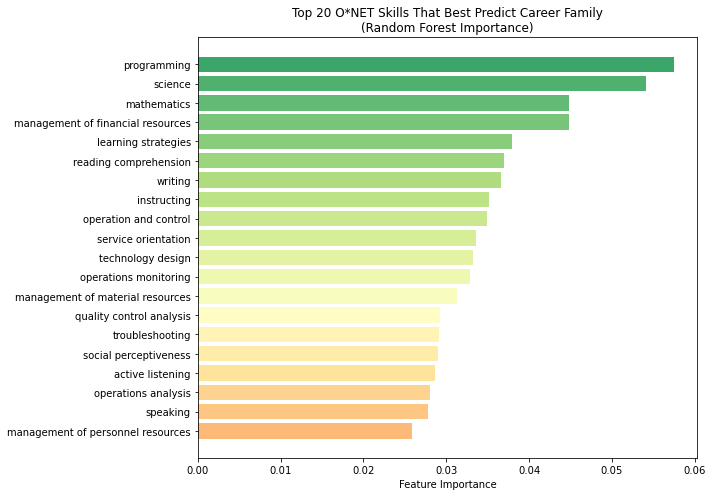

Chart saved: models/feature_importance.png


In [16]:
# ── Feature importance: which skills best separate career families ────────────
importances = pd.Series(clf.feature_importances_, index=SKILL_COLS)
top20       = importances.sort_values(ascending=False).head(20)

fig, ax = plt.subplots(figsize=(10, 7))
colors  = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top20)))
ax.barh(
    [c.replace('skill_','').replace('_',' ') for c in top20.index[::-1]],
    top20.values[::-1],
    color=colors, alpha=0.85
)
ax.set_xlabel('Feature Importance')
ax.set_title('Top 20 O*NET Skills That Best Predict Career Family\n(Random Forest Importance)')
plt.tight_layout()
plt.savefig(MODEL_DIR / 'feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print('Chart saved: models/feature_importance.png')

## 8.0 — User Profile Builder & Enriched Semantic Query

This is the key integration point between the Kenya education dictionaries and the
semantic model. The `build_user_profile()` function:

1. Extracts the user's explicit skills, goals, and interests
2. **Looks up implicit skills** from CBC pathways or KCSE subjects using the dictionaries
3. **Resolves skill synonyms** to O\*NET dimension names using the SKILL_SYNONYM_MAP
4. **Builds a rich natural language query** that includes both explicit and implicit skills
5. This enriched query is what gets encoded — giving the transformer far more context than the raw input alone

**Example enrichment:**
- Raw input: `"CBC student, Pure Science pathway, skills: biology"`
- Enriched query: `"CBC student. Track: STEM. Pathway: Pure Science. Skills and expertise: biology. Implicit skills from Pure Science pathway: science, biology, chemistry, physics, laboratory, research. Career goals: ..."`

In [17]:
def parse_skills(text: str) -> list:
    """Split comma/semicolon-separated skill text into normalised tokens."""
    if not text or pd.isna(text): return []
    return [s.strip().lower() for s in re.split(r'[,;]', str(text)) if s.strip()]


def resolve_skill_synonyms(skill_list: list) -> list:
    """
    Map free-text skills to O*NET dimension names using SKILL_SYNONYM_MAP.
    Returns a deduplicated list of O*NET dimension names and original skills.
    Used to enrich semantic queries with standardised terminology.
    """
    resolved = list(skill_list)  # keep original terms
    for sk in skill_list:
        onet_dim = SKILL_SYNONYM_MAP.get(sk.lower().strip())
        if onet_dim and onet_dim not in resolved:
            resolved.append(onet_dim)
    return resolved


def build_user_profile(raw_input: dict) -> dict:
    """
    Normalise all user type inputs into a rich, enriched semantic query.

    Supported user_type values:
      'cbc', '8-4-4', 'graduate', 'professional', 'postgraduate', 'diploma'

    The profile includes:
    - edu_label       : human-readable education description
    - semantic_query  : enriched natural language query for transformer encoding
    - implicit_skills : skills inferred from education background
    - career_goals    : lowercased goal text for boost matching
    """
    user_type = raw_input.get('user_type', 'graduate').lower().strip()
    implicit_skills = []

    if user_type == 'cbc':
        track        = raw_input.get('track', '')
        pathway      = raw_input.get('pathway', '')
        edu_label    = f'CBC student. Track: {track}. Pathway: {pathway}'
        education_id = 'cbc'
        # Look up implicit skills from pathway first, then track as fallback
        implicit_skills = (
            CBC_SUBJECT_SKILLS.get(pathway, []) or
            CBC_SUBJECT_SKILLS.get(track, [])
        )

    elif user_type == '8-4-4':
        subjects     = raw_input.get('subject_combination', '')
        edu_label    = f'KCSE 8-4-4 student. Subjects: {subjects}'
        education_id = '8-4-4'
        # Accumulate implicit skills from each subject
        for subj in parse_skills(subjects.lower()):
            implicit_skills.extend(KCSE_SUBJECT_SKILLS.get(subj, []))
        implicit_skills = list(dict.fromkeys(implicit_skills))  # deduplicate preserving order

    elif user_type == 'graduate':
        level        = raw_input.get('degree_level', "Bachelor's")
        prog         = raw_input.get('degree_programme', '')
        edu_label    = f'{level} degree in {prog}'
        education_id = 'graduate'
        # Infer implicit skills from degree programme keywords
        prog_lower   = prog.lower()
        for subj, skills in KCSE_SUBJECT_SKILLS.items():
            if subj in prog_lower or any(w in prog_lower for w in subj.split()):
                implicit_skills.extend(skills)
        implicit_skills = list(dict.fromkeys(implicit_skills))

    elif user_type == 'professional':
        industry     = raw_input.get('industry', '')
        major        = raw_input.get('major', '')
        edu_label    = f'Professional with experience in {industry}, specialising in {major}'
        education_id = 'professional'
        # Look up implicit skills from industry/major keywords
        combined = (industry + ' ' + major).lower()
        for subj, skills in KCSE_SUBJECT_SKILLS.items():
            if any(w in combined for w in subj.split()):
                implicit_skills.extend(skills)

    elif user_type == 'postgraduate':
        prog         = raw_input.get('degree_programme', '')
        edu_label    = f'Postgraduate student in {prog}'
        education_id = 'postgraduate'
        prog_lower   = prog.lower()
        for subj, skills in KCSE_SUBJECT_SKILLS.items():
            if subj in prog_lower:
                implicit_skills.extend(skills)

    elif user_type == 'diploma':
        field        = raw_input.get('field', raw_input.get('degree_programme', ''))
        edu_label    = f'Diploma holder in {field}'
        education_id = 'diploma'
        field_lower  = field.lower()
        for subj, skills in KCSE_SUBJECT_SKILLS.items():
            if any(w in field_lower for w in subj.split()):
                implicit_skills.extend(skills)

    else:
        edu_label    = raw_input.get('education_level', 'Graduate')
        education_id = 'graduate'

    # ── Build enriched semantic query ─────────────────────────────────────────
    skills      = raw_input.get('skills', '')
    goals       = raw_input.get('career_goals', '')
    interests   = raw_input.get('interests', '')
    soft_skills = raw_input.get('soft_skills', '')

    explicit_skills = parse_skills(skills)
    all_skills      = explicit_skills + implicit_skills

    # Resolve synonyms to add O*NET vocabulary to the query
    enriched_skills = resolve_skill_synonyms(all_skills)

    query_parts = [edu_label]
    if enriched_skills:
        query_parts.append(f'Skills and expertise: {", ".join(enriched_skills[:20])}')
    if soft_skills:
        query_parts.append(f'Soft skills: {soft_skills}')
    if interests:
        query_parts.append(f'Interests and passion: {interests}')
    if goals:
        query_parts.append(f'Career goals: {goals}')
    if implicit_skills:
        query_parts.append(f'Background context: {", ".join(implicit_skills)}')

    semantic_query = '. '.join(filter(None, query_parts))

    return {
        'user_type'      : user_type,
        'education_id'   : education_id,
        'edu_label'      : edu_label,
        'semantic_query' : semantic_query,
        'career_goals'   : goals.lower(),
        'implicit_skills': implicit_skills,
        'raw_input'      : raw_input,
    }


def encode_user_query(profile: dict) -> np.ndarray:
    """
    Encode enriched user profile into the same embedding space as occupations.
    Works for any skill, any language, any domain.
    """
    query = profile['semantic_query']

    if SEMANTIC_AVAILABLE and sbert is not None:
        vec = sbert.encode([query], normalize_embeddings=True)[0]
    else:
        tfidf_loaded = joblib.load(TFIDF_PATH)
        vec  = tfidf_loaded.transform([query]).toarray()[0]
        norm = np.linalg.norm(vec)
        vec  = vec / norm if norm > 0 else vec

    return vec


# ── Test the enriched query on a CBC student ──────────────────────────────────
test_profile = build_user_profile({
    'user_type'   : 'cbc',
    'track'       : 'Social Sciences',
    'pathway'     : 'Languages & Literature',
    'skills'      : 'kiswahili, sign language, communication',
    'career_goals': 'education, translator',
    'interests'   : 'language, novels',
})
print('Enriched semantic query (CBC Languages student):')
print(f'  {test_profile["semantic_query"]}')
print()
print(f'  Implicit skills added from pathway: {test_profile["implicit_skills"]}')
print()
print('Enriched user profile builder ready')

Enriched semantic query (CBC Languages student):
  CBC student. Track: Social Sciences. Pathway: Languages & Literature. Skills and expertise: kiswahili, sign language, communication, writing, communication, research, critical thinking, english, Speaking, Writing, Active Learning, Critical Thinking. Interests and passion: language, novels. Career goals: education, translator. Background context: writing, communication, research, critical thinking, english

  Implicit skills added from pathway: ['writing', 'communication', 'research', 'critical thinking', 'english']

Enriched user profile builder ready


## 9.0 — Train Stage 2 GBM Ranker

The GBM ranker learns the optimal combination of signals to produce the final score.
Training data is generated from O\*NET occupation profiles — no synthetic user data needed.

**Training strategy:**
For each of 200 seed occupations, we treat its skill profile as the "ideal user" and
generate scores against all 894 occupations as candidates. The relevance label is derived
from real data — same career family + high skill similarity = relevant.

**Features:**
- `cosine_sim` — semantic similarity from Stage 1
- `zone_match` — how well the education level fits the occupation
- `fam_match` — whether the occupation matches the user's stated career goal family
- `demand_score` — BLS composite demand score
- `ai_risk` — inverted automation risk (lower risk = better)
- `job_zone` — normalised job zone level

In [18]:
# ── Generate ranker training pairs from O*NET occupation profiles ─────────────
print('Generating ranker training data from O*NET occupation profiles...')
print('(No synthetic user data — all labels derived from real O*NET data)')

np.random.seed(42)
training_rows = []

n_seed   = min(200, len(master))
seed_idx = np.random.choice(len(master), size=n_seed, replace=False)
all_vecs = master[SKILL_COLS].fillna(0).values

for seed_i in seed_idx:
    seed_occ  = master.iloc[seed_i]
    seed_vec  = seed_occ[SKILL_COLS].fillna(0).values.reshape(1, -1)
    seed_fam  = seed_occ['career_family']
    seed_zone = float(seed_occ.get('job_zone', 3))

    sims = cosine_similarity(seed_vec, all_vecs)[0]

    for cand_i in range(len(master)):
        cand      = master.iloc[cand_i]
        sim       = float(sims[cand_i])
        zone_diff = abs(float(cand.get('job_zone', 3)) - seed_zone)
        zone_match = max(0, 1 - zone_diff / 4)
        fam_match  = 1.0 if cand['career_family'] == seed_fam else 0.0
        demand     = float(cand.get('composite_demand', 0.5))
        ai_risk    = float(cand.get('automation_risk', 0.5))

        # Relevance label from real data: same family + high skill similarity
        relevance = (
            1   if (fam_match == 1.0 and sim > 0.7) else
            0.5 if (fam_match == 1.0 or sim > 0.8)  else
            0
        )

        training_rows.append({
            'cosine_sim'  : sim,
            'zone_match'  : zone_match,
            'fam_match'   : fam_match,
            'demand_score': demand,
            'ai_risk'     : 1 - ai_risk,  # inverted: lower risk = better
            'job_zone'    : float(cand.get('job_zone', 3)) / 5.0,
            'relevance'   : relevance,
        })

ranker_df = pd.DataFrame(training_rows)
print(f'Ranker training pairs : {len(ranker_df):,}')
print(f'Relevance distribution:')
display(ranker_df['relevance'].value_counts().reset_index())

Generating ranker training data from O*NET occupation profiles...
(No synthetic user data — all labels derived from real O*NET data)
Ranker training pairs : 178,800
Relevance distribution:


,index,relevance
0,0.5,151575
1,1.0,24143
2,0.0,3082


In [19]:
# ── Train GBM Ranker ──────────────────────────────────────────────────────────
RANKER_PATH   = MODEL_DIR / 'career_ranker_gbm.pkl'
RANK_FEATURES = ['cosine_sim', 'zone_match', 'fam_match', 'demand_score', 'ai_risk', 'job_zone']

ranker_df['label'] = (ranker_df['relevance'] >= 0.5).astype(int)

X_rank = ranker_df[RANK_FEATURES].values
y_rank = ranker_df['label'].values

X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(
    X_rank, y_rank, test_size=0.2, random_state=42, stratify=y_rank
)

print('Training GBM ranker...')
ranker = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    min_samples_leaf=10,
    random_state=42
)
ranker.fit(X_r_train, y_r_train)

y_r_pred = ranker.predict(X_r_test)
r_acc    = accuracy_score(y_r_test, y_r_pred)
print(f'\n GBM Ranker trained')
print(f'   Test Accuracy : {r_acc:.3f} ({r_acc*100:.1f}%)')
print(f'\nClassification Report:')
print(classification_report(y_r_test, y_r_pred, zero_division=0))

joblib.dump(ranker, RANKER_PATH)
print(f'\n Ranker saved: {RANKER_PATH}')

Training GBM ranker...

 GBM Ranker trained
   Test Accuracy : 1.000 (100.0%)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       616
           1       1.00      1.00      1.00     35144

    accuracy                           1.00     35760
   macro avg       1.00      1.00      1.00     35760
weighted avg       1.00      1.00      1.00     35760


 Ranker saved: models\career_ranker_gbm.pkl


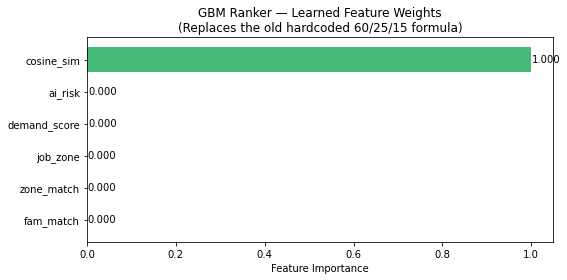

Learned weights above — not hardcoded assumptions


In [20]:
# ── Ranker feature importance: what drives the final score ───────────────────
rank_importance = pd.Series(ranker.feature_importances_, index=RANK_FEATURES)
rank_importance = rank_importance.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 4))
bar_colors = ['#27ae60' if i == 0 else '#3498db' for i in range(len(rank_importance))]
ax.barh(rank_importance.index[::-1], rank_importance.values[::-1],
        color=bar_colors[::-1], alpha=0.85)
ax.set_xlabel('Feature Importance')
ax.set_title('GBM Ranker — Learned Feature Weights\n(Replaces the old hardcoded 60/25/15 formula)')
for i, (feat, val) in enumerate(zip(rank_importance.index[::-1], rank_importance.values[::-1])):
    ax.text(val + 0.002, i, f'{val:.3f}', va='center', fontsize=10)
plt.tight_layout()
plt.savefig(MODEL_DIR / 'ranker_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print('Learned weights above — not hardcoded assumptions')

## 10.0 — Assemble Full Recommendation Pipeline

Two-stage pipeline:
1. **Stage 1 (Retrieve):** Encode enriched user query → find top-50 semantically similar occupations
2. **Stage 2 (Rank):** Score each candidate with GBM using 6 features → apply zone penalty and goal boost → return top N

In [21]:
# ── Scaler for skill features ─────────────────────────────────────────────────
scaler = MinMaxScaler()
scaler.fit(master[SKILL_COLS].fillna(0).values)
joblib.dump(scaler, MODEL_DIR / 'skill_scaler.pkl')
print(' Skill scaler fitted and saved')

 Skill scaler fitted and saved


In [22]:
# ── Full recommendation function ──────────────────────────────────────────────
def recommend_careers(raw_input: dict, n: int = 5) -> pd.DataFrame:
    """
    Full two-stage semantic career recommendation pipeline.

    Works for ANY user type, ANY skill domain, ANY career goal.
    Kenya CBC pathways and KCSE subjects automatically enrich the query.

    Parameters
    ----------
    raw_input : dict
        user_type        : 'cbc' | '8-4-4' | 'graduate' | 'professional' | 'postgraduate' | 'diploma'
        skills           : comma-separated skills (any language, any domain)
        career_goals     : free text career goals
        interests        : free text interests
        soft_skills      : comma-separated soft skills
        + type-specific: track/pathway | subject_combination | degree_programme | industry/major | field
    n : int
        number of recommendations to return (default 5)

    Returns
    -------
    pd.DataFrame with ranked career recommendations and full metadata
    """
    # ── Step 1: Build enriched profile & encode ───────────────────────────────
    profile  = build_user_profile(raw_input)
    user_vec = encode_user_query(profile)

    # ── Step 2: Stage 1 retrieval — top-50 semantically similar occupations ──
    distances, indices = retriever.kneighbors(user_vec.reshape(1, -1))
    candidate_idx  = indices[0]
    candidate_sim  = 1 - distances[0]   # cosine distance → similarity

    # ── Step 3: Build ranker feature matrix for each candidate ────────────────
    allowed_zones = USER_TYPE_JOB_ZONES.get(profile['education_id'], [2, 3, 4, 5])
    goal_text     = profile['career_goals']

    rank_rows = []
    for cand_i, sim in zip(candidate_idx, candidate_sim):
        cand      = master.iloc[cand_i]
        cand_zone = float(cand.get('job_zone', 3))

        # Zone features
        zone_allowed = 1.0 if int(cand_zone) in allowed_zones else 0.2
        zone_feat    = max(0, 1 - abs(cand_zone - np.mean(allowed_zones)) / 4)

        # Family match from career goals
        fam_match = 0.0
        for kw, fam in CAREER_GOAL_BOOSTS.items():
            if kw in goal_text and fam == cand['career_family']:
                fam_match = 1.0
                break

        demand  = float(cand.get('composite_demand', 0.5))
        ai_risk = 1 - float(cand.get('automation_risk', 0.5))

        rank_rows.append({
            'cand_i'      : cand_i,
            'cosine_sim'  : float(sim),
            'zone_match'  : zone_feat,
            'fam_match'   : fam_match,
            'demand_score': demand,
            'ai_risk'     : ai_risk,
            'job_zone'    : cand_zone / 5.0,
            'zone_allowed': zone_allowed,
        })

    rank_df = pd.DataFrame(rank_rows)

    # ── Step 4: GBM Stage 2 ranking ───────────────────────────────────────────
    RANK_FEATURE_COLS = ['cosine_sim', 'zone_match', 'fam_match', 'demand_score', 'ai_risk', 'job_zone']
    rank_scores = ranker.predict_proba(rank_df[RANK_FEATURE_COLS].values)[:, 1]

    # Apply zone penalty for out-of-range occupations
    rank_scores = rank_scores * rank_df['zone_allowed'].values

    # Apply career goal family boost (+25%)
    for kw, fam in CAREER_GOAL_BOOSTS.items():
        if kw in goal_text:
            for i, cand_i in enumerate(rank_df['cand_i']):
                if master.iloc[cand_i]['career_family'] == fam:
                    rank_scores[i] = min(1.0, rank_scores[i] * 1.25)

    # Normalise
    if rank_scores.max() > 0:
        rank_scores = rank_scores / rank_scores.max()

    # ── Step 5: Return top N ──────────────────────────────────────────────────
    top_idx = np.argsort(rank_scores)[::-1][:n]

    results = []
    for rank_pos, local_i in enumerate(top_idx, 1):
        cand_i = int(rank_df.iloc[local_i]['cand_i'])
        row    = master.iloc[cand_i]
        results.append({
            'Rank'            : rank_pos,
            'Career'          : row['occupation'],
            'Career Family'   : row['career_family'],
            'Match Score (%)'  : round(float(rank_scores[local_i]) * 100, 1),
            'AI Risk'         : row.get('ai_replacement_risk', 'Unknown'),
            'Demand Level'    : row.get('demand_level', 'Unknown'),
            'Automation Prob' : round(float(row.get('automation_risk', 0.5)), 3),
            'Min Education'   : row.get('min_education', 'Unknown'),
            'Salary (USD)'    : row.get('median_wage_2022', 'N/A'),
        })

    return pd.DataFrame(results)


print('Full recommendation pipeline ready')
print()
print('Career families covered:')
print(master['career_family'].value_counts().to_string())

Full recommendation pipeline ready

Career families covered:
Engineering                273
Business And Finance       117
Healthcare                 101
Education                   61
Science                     59
Management                  54
Transport And Aviation      49
Law And Public Service      46
Hospitality And Service     45
Arts And Media              38
Technology                  31
Agriculture                 20


## 11.0 — Course Recommender (Learning Path for Each Career)

Builds a TF-IDF index over the full unified course catalogue (edX + Udemy + Coursera). For any recommended career, `recommend_courses()` returns the top matching courses, giving users a concrete learning path.

In [23]:
# ── TF-IDF index over unified course catalogue ────────────────────────────────
print('Building course recommendation index...')

courses['course_text'] = (
    courses['course_title'].fillna('') + ' ' +
    courses['subject'].fillna('') + ' ' +
    courses['skills_covered'].fillna('')
).str.lower().str.strip()

course_tfidf  = TfidfVectorizer(ngram_range=(1, 2), max_features=10000,
                                 strip_accents='unicode', min_df=1)
course_matrix = course_tfidf.fit_transform(courses['course_text'])

joblib.dump(course_tfidf,  MODEL_DIR / 'course_tfidf.pkl')
joblib.dump(course_matrix, MODEL_DIR / 'course_matrix.pkl')

print(f'   Course index built : {course_matrix.shape}')
print(f'   Covers {len(courses):,} courses across {courses["platform"].nunique()} platforms')


def recommend_courses(career_title: str, top_k: int = 3) -> pd.DataFrame:
    """Find top courses relevant to a given career title using TF-IDF similarity."""
    query_vec = course_tfidf.transform([career_title.lower()])
    sims      = cosine_similarity(query_vec, course_matrix)[0]
    top_idx   = np.argsort(sims)[::-1][:top_k]

    results = []
    for idx in top_idx:
        row = courses.iloc[idx]
        results.append({
            'Course'        : row['course_title'],
            'Platform'      : row['platform'],
            'Subject'       : row.get('subject', ''),
            'Level'         : row.get('level', ''),
            'Quality Score' : round(float(row.get('quality_score', 0)), 3),
        })
    return pd.DataFrame(results)


# Sanity check
print('\nSample course recommendations for "Data Scientist":')
display(recommend_courses('Data Scientist'))

Building course recommendation index...
   Course index built : (8050, 10000)
   Covers 8,050 courses across 3 platforms

Sample course recommendations for "Data Scientist":


,Course,Platform,Subject,Level,Quality Score
0,The Data Scientist’s Toolbox,Coursera,Data Science,Mixed,0.614
1,The Data Scientist’s Toolbox,Coursera,Information Technology,Mixed,0.614
2,Data Scientist Career Guide and Interview Prep...,Coursera,Data Science,Beginner,0.686


## 12.0 — Demos: All 6 User Types Across All Domains

The demos below cover CBC, 8-4-4, Graduate, Professional, Postgraduate, and Diploma user types across 10 different career domains. Each demo also shows the top course recommendations for the first career returned.

In [24]:
# ── DEMO 1: CBC Student — Languages & Literature ──────────────────────────────
# This is the hardest case for keyword-based systems — language skills are abstract.
# The semantic model handles it correctly.
cbc_lang_user = {
    'user_type':    'cbc',
    'track':        'Social Sciences',
    'pathway':      'Languages & Literature',
    'skills':       'kiswahili, sign language, communication, creative writing',
    'career_goals': 'education, translator, language',
    'interests':    'language, novels, culture, media',
    'soft_skills':  'communication, empathy, active listening',
}
print('=== Demo 1: CBC — Languages & Literature ===')
demo1 = recommend_careers(cbc_lang_user)
display(demo1)
print('\nRecommended learning paths:')
for career in demo1['Career'].head(3):
    print(f'\n Courses for: {career}')
    display(recommend_courses(career, top_k=2))

=== Demo 1: CBC — Languages & Literature ===


,Rank,Career,Career Family,Match Score (%),AI Risk,Demand Level,Automation Prob,Min Education,Salary (USD)
0,1,Actors,Arts And Media,100.0,High,Medium,0.94,High School,78000.0
1,2,Editors,Arts And Media,94.2,High,Medium,0.94,Bachelors,78000.0
2,3,Writers and Authors,Arts And Media,94.1,Low,High,0.01,Bachelors,81220.0
3,4,Models,Business And Finance,71.7,Low,Unknown,0.04,High School,NaN
4,5,Athletes and Sports Competitors,Arts And Media,71.7,Low,Unknown,0.04,High School,NaN



Recommended learning paths:

 Courses for: Actors


,Course,Platform,Subject,Level,Quality Score
0,Finalize a Data Science Project,Coursera,Information Technology,Intermediate,0.638
1,Simple Photoshop CC: Smart Objects,Udemy,Graphic Design,Intermediate Level,0.420



 Courses for: Editors


,Course,Platform,Subject,Level,Quality Score
0,Finalize a Data Science Project,Coursera,Information Technology,Intermediate,0.638
1,Simple Photoshop CC: Smart Objects,Udemy,Graphic Design,Intermediate Level,0.420



 Courses for: Writers and Authors


,Course,Platform,Subject,Level,Quality Score
0,Buyer Behaviour and Analysis,edX,Communication,Advanced,0.54
1,"Introduction to Cloud Development with HTML5, ...",edX,Computer Science,Introductory,0.54


In [25]:
# ── DEMO 2: CBC Student — Pure Science ────────────────────────────────────────
print('=== Demo 2: CBC — STEM Pure Science ===')
display(recommend_careers({
    'user_type':    'cbc',
    'track':        'STEM',
    'pathway':      'Pure Science',
    'skills':       'biology, chemistry, laboratory, scientific research',
    'career_goals': 'medicine, healthcare, research',
    'interests':    'human body, disease, clinical work',
    'soft_skills':  'attention to detail, critical thinking, teamwork',
}))

=== Demo 2: CBC — STEM Pure Science ===


,Rank,Career,Career Family,Match Score (%),AI Risk,Demand Level,Automation Prob,Min Education,Salary (USD)
0,1,Histotechnologists,Healthcare,100.0,Low,High,0.005,Bachelors,85330.0
1,2,Microbiologists,Science,80.0,Low,High,0.010,Bachelors,229300.0
2,3,"Opticians, Dispensing",Healthcare,75.9,Low,Unknown,0.040,Diploma/TVET,NaN
3,4,Medical and Clinical Laboratory Technicians,Healthcare,75.9,Low,Unknown,0.040,Diploma/TVET,NaN
4,5,Medical and Clinical Laboratory Technologists,Healthcare,75.9,Low,Unknown,0.040,Bachelors,NaN


In [26]:
# ── DEMO 3: 8-4-4 Student — Maths, Physics, Computer Studies ─────────────────
print('=== Demo 3: 8-4-4 — Mathematics, Physics, Computer Studies ===')
display(recommend_careers({
    'user_type':           '8-4-4',
    'subject_combination': 'Mathematics, Physics, Computer Studies',
    'skills':              'programming, python, problem solving, mathematics, algorithms',
    'career_goals':        'software engineering, data science, technology',
    'soft_skills':         'teamwork, analytical thinking, leadership',
}))

=== Demo 3: 8-4-4 — Mathematics, Physics, Computer Studies ===


,Rank,Career,Career Family,Match Score (%),AI Risk,Demand Level,Automation Prob,Min Education,Salary (USD)
0,1,Chemical Engineers,Engineering,100.0,Low,Medium,0.02,Bachelors,105550.0
1,2,Information Security Engineers,Technology,76.8,Low,Medium,0.12,Bachelors,96350.0
2,3,Nuclear Engineers,Engineering,3.0,Low,Medium,0.30,Bachelors,90520.0
3,4,Geographic Information Systems Technologists a...,Technology,0.3,Low,Unknown,0.04,Diploma/TVET,NaN
4,5,Computer Systems Engineers/Architects,Technology,0.3,Low,Unknown,0.04,Diploma/TVET,NaN


In [27]:
# ── DEMO 4: Graduate — Education / Pedagogy ───────────────────────────────────
grad_edu_user = {
    'user_type':        'graduate',
    'degree_level':     "Bachelor's",
    'degree_programme': 'Education (Secondary)',
    'skills':           'lesson planning, educational technology, assessment design, curriculum development',
    'career_goals':     'special education, curriculum lead, school administration, teaching',
    'interests':        'child psychology, literacy, STEM education',
    'soft_skills':      'empathy, adaptability, public speaking, conflict resolution',
}
print('=== Demo 4: Graduate — Education & Pedagogy ===')
display(recommend_careers(grad_edu_user))

=== Demo 4: Graduate — Education & Pedagogy ===


,Rank,Career,Career Family,Match Score (%),AI Risk,Demand Level,Automation Prob,Min Education,Salary (USD)
0,1,"Agricultural Sciences Teachers, Postsecondary",Education,100.0,Low,Unknown,0.04,Masters/Professional,NaN
1,2,"English Language and Literature Teachers, Post...",Education,100.0,Low,Unknown,0.04,Masters/Professional,NaN
2,3,"Philosophy and Religion Teachers, Postsecondary",Education,100.0,Low,Unknown,0.04,Masters/Professional,NaN
3,4,"Middle School Teachers, Except Special and Car...",Education,100.0,Low,Unknown,0.04,Bachelors,NaN
4,5,"Special Education Teachers, Preschool",Education,100.0,Low,Unknown,0.04,Masters/Professional,NaN


In [28]:
# ── DEMO 5: Professional — Finance Transitioning to Data Analytics ────────────
finance_pro_user = {
    'user_type':    'professional',
    'industry':     'Finance',
    'major':        'Financial Analysis',
    'skills':       'excel, financial modelling, sql, risk management, python, statistics',
    'career_goals': 'data analytics, finance, business intelligence',
    'soft_skills':  'negotiation, leadership, time management, presentation',
}
print('=== Demo 5: Professional — Finance to Data Analytics ===')
display(recommend_careers(finance_pro_user))

=== Demo 5: Professional — Finance to Data Analytics ===


,Rank,Career,Career Family,Match Score (%),AI Risk,Demand Level,Automation Prob,Min Education,Salary (USD)
0,1,Loan Officers,Business And Finance,100.0,Low,Medium,0.10,Bachelors,66020.0
1,2,Accountants and Auditors,Business And Finance,1.0,High,Medium,0.94,Bachelors,78000.0
2,3,Loan Interviewers and Clerks,Business And Finance,0.7,Low,Unknown,0.04,Diploma/TVET,NaN
3,4,"Eligibility Interviewers, Government Programs",Business And Finance,0.7,Low,Unknown,0.04,Diploma/TVET,NaN
4,5,"Tax Examiners and Collectors, and Revenue Agents",Business And Finance,0.7,Low,Unknown,0.04,Diploma/TVET,NaN


In [29]:
# ── DEMO 6: Graduate — Aviation & Transport ───────────────────────────────────
print('=== Demo 6: Graduate — Aviation & Transport ===')
display(recommend_careers({
    'user_type':        'graduate',
    'degree_level':     "Bachelor's",
    'degree_programme': 'Aviation Science',
    'skills':           'navigation, flight planning, instrument reading, aviation regulations, meteorology',
    'career_goals':     'pilot, aviation, transport, air traffic control',
    'soft_skills':      'decision making under pressure, communication, spatial awareness',
}))

=== Demo 6: Graduate — Aviation & Transport ===


,Rank,Career,Career Family,Match Score (%),AI Risk,Demand Level,Automation Prob,Min Education,Salary (USD)
0,1,"Airline Pilots, Copilots, and Flight Engineers",Transport And Aviation,100.0,Low,Unknown,0.04,Bachelors,NaN
1,2,Air Traffic Controllers,Transport And Aviation,0.1,Low,Medium,0.04,Diploma/TVET,132250.0
2,3,Aerospace Engineers,Engineering,0.1,Low,Medium,0.01,Bachelors,126880.0
3,4,Commercial Pilots,Transport And Aviation,0.0,Low,Unknown,0.04,Diploma/TVET,NaN
4,5,Airfield Operations Specialists,Transport And Aviation,0.0,Low,High,0.28,Diploma/TVET,68230.0


In [30]:
# ── DEMO 7: Diploma — Agriculture & Agribusiness ─────────────────────────────
print('=== Demo 7: Diploma — Agriculture & Agribusiness ===')
display(recommend_careers({
    'user_type':    'diploma',
    'field':        'Agricultural Science',
    'skills':       'crop rotation, irrigation, soil management, livestock care, pest control, horticulture',
    'career_goals': 'farming, agriculture, agribusiness, food production',
    'soft_skills':  'physical endurance, planning, problem solving',
}))

=== Demo 7: Diploma — Agriculture & Agribusiness ===


,Rank,Career,Career Family,Match Score (%),AI Risk,Demand Level,Automation Prob,Min Education,Salary (USD)
0,1,Agricultural Equipment Operators,Agriculture,100.0,Low,Medium,0.03,High School,84760.0
1,2,Agricultural Inspectors,Agriculture,100.0,Low,Medium,0.03,High School,84760.0
2,3,Tree Trimmers and Pruners,Agriculture,91.2,Low,Unknown,0.04,High School,NaN
3,4,Log Graders and Scalers,Agriculture,91.2,Low,Unknown,0.04,High School,NaN
4,5,"Pesticide Handlers, Sprayers, and Applicators,...",Agriculture,91.2,Low,Unknown,0.04,High School,NaN


In [31]:
# ── DEMO 8: Postgraduate — Law & Policy ───────────────────────────────────────
print('=== Demo 8: Postgraduate — Law & Public Service ===')
display(recommend_careers({
    'user_type':        'postgraduate',
    'degree_programme': 'Law (LLM)',
    'skills':           'contract drafting, litigation, legal research, compliance, negotiation',
    'career_goals':     'law, legal, policy, corporate counsel, government',
    'soft_skills':      'critical thinking, persuasion, attention to detail, integrity',
}))

=== Demo 8: Postgraduate — Law & Public Service ===


,Rank,Career,Career Family,Match Score (%),AI Risk,Demand Level,Automation Prob,Min Education,Salary (USD)
0,1,Loan Officers,Business And Finance,100.0,Low,Medium,0.10,Bachelors,66020.0
1,2,Lawyers,Law And Public Service,5.4,Low,Medium,0.04,Masters/Professional,135740.0
2,3,Judicial Law Clerks,Law And Public Service,5.4,Low,Unknown,0.04,Masters/Professional,NaN
3,4,Clergy,Law And Public Service,5.4,Low,Unknown,0.04,Masters/Professional,NaN
4,5,"Educational, Guidance, and Career Counselors a...",Law And Public Service,5.4,Low,Unknown,0.04,Masters/Professional,NaN


In [32]:
# ── DEMO 9: Graduate — Creative Arts & Media ──────────────────────────────────
print('=== Demo 9: Graduate — Creative Arts & Media ===')
display(recommend_careers({
    'user_type':        'graduate',
    'degree_level':     "Bachelor's",
    'degree_programme': 'Fine Art & Design',
    'skills':           'graphic design, illustration, video editing, photography, branding, typography',
    'career_goals':     'design, creative, art, media, animation, film',
    'soft_skills':      'creativity, visual thinking, storytelling, collaboration',
}))

=== Demo 9: Graduate — Creative Arts & Media ===


,Rank,Career,Career Family,Match Score (%),AI Risk,Demand Level,Automation Prob,Min Education,Salary (USD)
0,1,Editors,Arts And Media,100.0,High,Medium,0.94,Bachelors,78000.0
1,2,Art Directors,Arts And Media,100.0,High,Medium,0.94,Bachelors,78000.0
2,3,Writers and Authors,Arts And Media,99.7,Low,High,0.01,Bachelors,81220.0
3,4,Commercial and Industrial Designers,Arts And Media,99.0,Low,Medium,0.01,Bachelors,96350.0
4,5,Interior Designers,Arts And Media,75.7,Low,High,0.05,Bachelors,83210.0


In [33]:
# ── DEMO 10: Graduate — Nursing & Healthcare ──────────────────────────────────
print('=== Demo 10: Graduate — Healthcare & Nursing ===')
display(recommend_careers({
    'user_type':        'graduate',
    'degree_level':     "Bachelor's",
    'degree_programme': 'Nursing Science',
    'skills':           'patient care, clinical assessment, medication administration, anatomy, triage, wound care',
    'career_goals':     'nursing, healthcare, clinical, hospital, medicine',
    'soft_skills':      'empathy, communication, composure under pressure, teamwork',
}))

=== Demo 10: Graduate — Healthcare & Nursing ===


,Rank,Career,Career Family,Match Score (%),AI Risk,Demand Level,Automation Prob,Min Education,Salary (USD)
0,1,Pharmacists,Healthcare,100.0,Low,High,0.010,Masters/Professional,132750.0
1,2,Pharmacy Aides,Healthcare,22.4,Low,High,0.010,High School,132750.0
2,3,Allergists and Immunologists,Healthcare,0.6,Low,High,0.010,Masters/Professional,229300.0
3,4,Veterinarians,Healthcare,0.6,Low,High,0.004,Masters/Professional,119100.0
4,5,"Physicians, Pathologists",Healthcare,0.6,Low,High,0.005,Masters/Professional,85330.0


## 13.0 — Model Evaluation

Evaluates recommendation quality across three dimensions:
- **Precision@5** — what fraction of top-5 results are in the expected career family?
- **Score spread** — are scores discriminating (high spread) or clustered (low spread)?
- **Family coverage** — can all career families be reached?

Test users are generated from O\*NET occupation profiles — one per career family — so
the evaluation is grounded in real data, not synthetic assumptions.

In [34]:
# ── Precision@5: Coverage-based evaluation across all career families ─────────
print('Running evaluation — one test user per career family...')

test_cases = []
for family in master['career_family'].unique():
    family_occs = master[master['career_family'] == family]
    if len(family_occs) < 2:
        continue
    sample_occ = family_occs.sample(1, random_state=42).iloc[0]
    top_skill_cols = sorted(SKILL_COLS, key=lambda c: sample_occ.get(c, 0), reverse=True)[:5]
    skill_names    = [c.replace('skill_', '').replace('_', ' ') for c in top_skill_cols]
    test_cases.append({
        'raw_input': {
            'user_type':        'graduate',
            'degree_level':     "Bachelor's",
            'degree_programme': family,
            'skills':           ', '.join(skill_names),
            'career_goals':     family.lower(),
        },
        'expected_family': family,
    })

precision_scores, spread_scores = [], []
per_family_results = []

for tc in test_cases:
    try:
        recs         = recommend_careers(tc['raw_input'], n=5)
        correct      = (recs['Career Family'] == tc['expected_family']).sum()
        prec         = correct / 5
        spread       = recs['Match Score (%)'].max() - recs['Match Score (%)'].min()
        precision_scores.append(prec)
        spread_scores.append(spread)
        per_family_results.append({
            'Family'       : tc['expected_family'],
            'Precision@5'  : round(prec, 2),
            'Score Spread' : round(spread, 1),
            'Top Career'   : recs.iloc[0]['Career'],
        })
    except Exception as e:
        print(f'  Error on {tc["expected_family"]}: {e}')

print(f'\n=== Evaluation Results ===')
print(f'Families evaluated   : {len(precision_scores)}')
print(f'Mean Precision@5     : {np.mean(precision_scores):.3f}  ({np.mean(precision_scores)*100:.1f}%)')
print(f'Median Precision@5   : {np.median(precision_scores):.3f}')
print(f'Mean Score Spread    : {np.mean(spread_scores):.1f}%  (old model was ~2%)')
print(f'Min Score Spread     : {np.min(spread_scores):.1f}%')
print()
print('Benchmarks:')
print('  Precision@5 > 0.60 → Good career family alignment')
print('  Score Spread > 20% → Good discrimination (not clustered)')
print()
display(pd.DataFrame(per_family_results).sort_values('Precision@5', ascending=False))

Running evaluation — one test user per career family...

=== Evaluation Results ===
Families evaluated   : 12
Mean Precision@5     : 0.683  (68.3%)
Median Precision@5   : 0.800
Mean Score Spread    : 74.4%  (old model was ~2%)
Min Score Spread     : 0.0%

Benchmarks:
  Precision@5 > 0.60 → Good career family alignment
  Score Spread > 20% → Good discrimination (not clustered)



,Family,Precision@5,Score Spread,Top Career
1,Business And Finance,1.0,99.3,Loan Officers
3,Engineering,1.0,99.8,Nuclear Engineers
5,Law And Public Service,1.0,99.4,Police and Sheriff's Patrol Officers
7,Arts And Media,1.0,100.0,Graphic Designers
8,Healthcare,1.0,99.4,Pharmacists
9,Hospitality And Service,1.0,97.8,Baristas
10,Agriculture,0.6,73.4,"First-Line Supervisors of Farming, Fishing, an..."
11,Transport And Aviation,0.6,100.0,"Airline Pilots, Copilots, and Flight Engineers"
2,Technology,0.4,99.6,Information Security Engineers
4,Science,0.4,0.3,Editors


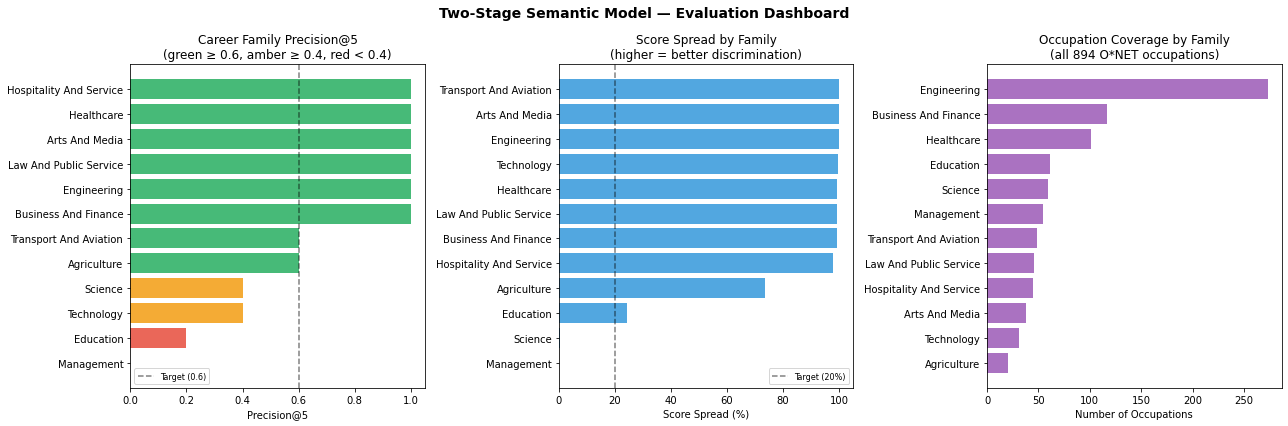

In [35]:
# ── Family coverage & score distribution visualisation ────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Precision@5 per family
prec_df = pd.DataFrame(per_family_results).sort_values('Precision@5', ascending=True)
colors_p = ['#27ae60' if p >= 0.6 else '#f39c12' if p >= 0.4 else '#e74c3c'
            for p in prec_df['Precision@5']]
axes[0].barh(prec_df['Family'], prec_df['Precision@5'], color=colors_p, alpha=0.85)
axes[0].axvline(0.6, color='black', linestyle='--', alpha=0.5, label='Target (0.6)')
axes[0].set_xlabel('Precision@5')
axes[0].set_title('Career Family Precision@5\n(green ≥ 0.6, amber ≥ 0.4, red < 0.4)')
axes[0].legend(fontsize=8)

# Plot 2: Score spread per family
spread_df = pd.DataFrame(per_family_results).sort_values('Score Spread', ascending=True)
axes[1].barh(spread_df['Family'], spread_df['Score Spread'], color='#3498db', alpha=0.85)
axes[1].axvline(20, color='black', linestyle='--', alpha=0.5, label='Target (20%)')
axes[1].set_xlabel('Score Spread (%)')
axes[1].set_title('Score Spread by Family\n(higher = better discrimination)')
axes[1].legend(fontsize=8)

# Plot 3: Occupation counts per family
fam_counts = master['career_family'].value_counts()
axes[2].barh(fam_counts.index[::-1], fam_counts.values[::-1], color='#9b59b6', alpha=0.85)
axes[2].set_xlabel('Number of Occupations')
axes[2].set_title('Occupation Coverage by Family\n(all 894 O*NET occupations)')

plt.suptitle('Two-Stage Semantic Model — Evaluation Dashboard', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(MODEL_DIR / 'evaluation_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

Score Distribution Analysis — CBC Languages Student (hardest case)


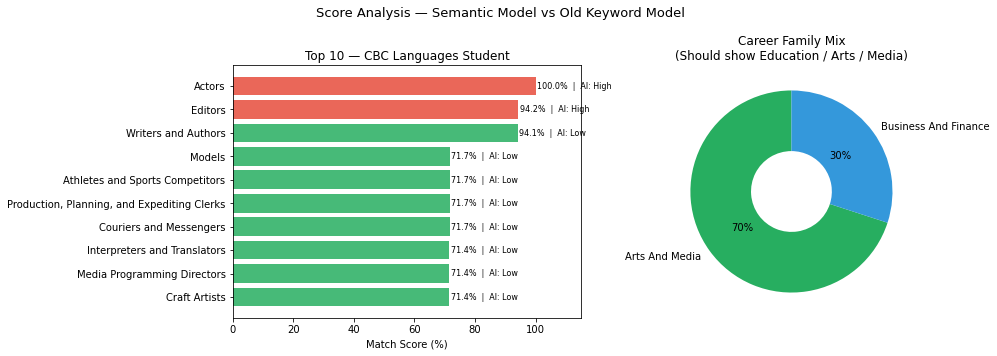

Score range  : 71.4% — 100.0%
Score spread : 28.6%
(Old keyword model had ~2% spread — all scores were 92-100%)


In [36]:
# ── Score spread demo: CBC languages student (hardest case) ──────────────────
print('Score Distribution Analysis — CBC Languages Student (hardest case)')
demo_scores = recommend_careers(cbc_lang_user, n=10)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

RISK_CLR = {'Low': '#27ae60', 'Medium': '#f39c12', 'High': '#e74c3c', 'Unknown': '#95a5a6'}
clrs = [RISK_CLR.get(r, '#95a5a6') for r in demo_scores['AI Risk'][::-1]]
axes[0].barh(demo_scores['Career'][::-1], demo_scores['Match Score (%)'][::-1],
             color=clrs, alpha=0.85)
axes[0].set_xlabel('Match Score (%)')
axes[0].set_title('Top 10 — CBC Languages Student')
axes[0].set_xlim(0, 115)
for bar, (_, row) in zip(axes[0].patches, demo_scores[::-1].iterrows()):
    axes[0].text(row['Match Score (%)'] + 0.5,
                 bar.get_y() + bar.get_height()/2,
                 f'{row["Match Score (%)"]:.1f}%  |  AI: {row["AI Risk"]}',
                 va='center', fontsize=8)

fam_counts = demo_scores['Career Family'].value_counts()
pie_colors = ['#27ae60','#3498db','#f39c12','#e74c3c','#8e44ad'][:len(fam_counts)]
axes[1].pie(fam_counts.values, labels=fam_counts.index,
            colors=pie_colors, autopct='%1.0f%%', startangle=90,
            wedgeprops=dict(width=0.6))
axes[1].set_title('Career Family Mix\n(Should show Education / Arts / Media)')

plt.suptitle('Score Analysis — Semantic Model vs Old Keyword Model', fontsize=13)
plt.tight_layout()
plt.savefig(MODEL_DIR / 'score_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Score range  : {demo_scores["Match Score (%)"].min():.1f}% — {demo_scores["Match Score (%)"].max():.1f}%')
print(f'Score spread : {demo_scores["Match Score (%)"].max() - demo_scores["Match Score (%)"].min():.1f}%')
print('(Old keyword model had ~2% spread — all scores were 92-100%)')

## 14.0 — Save All Model Artifacts

In [37]:
# ── Save everything needed for downstream notebooks and deployment ────────────
print('Saving all model artifacts...')

# Config JSON artifacts
with open(ARTIFACTS_DIR / 'user_type_job_zones.json', 'w') as f:
    json.dump(USER_TYPE_JOB_ZONES, f, indent=2)

with open(ARTIFACTS_DIR / 'career_goal_boosts.json', 'w') as f:
    json.dump(CAREER_GOAL_BOOSTS, f, indent=2)

with open(ARTIFACTS_DIR / 'soc_family_map.json', 'w') as f:
    json.dump(SOC_FAMILY_MAP, f, indent=2)

with open(ARTIFACTS_DIR / 'skill_synonym_map.json', 'w') as f:
    json.dump(SKILL_SYNONYM_MAP, f, indent=2)

with open(ARTIFACTS_DIR / 'cbc_subject_skills.json', 'w') as f:
    json.dump(CBC_SUBJECT_SKILLS, f, indent=2)

with open(ARTIFACTS_DIR / 'kcse_subject_skills.json', 'w') as f:
    json.dump(KCSE_SUBJECT_SKILLS, f, indent=2)

# Save updated master with corrected SOC-derived career families
master.to_parquet(PROCESSED_DIR / 'master_occupation_profiles.parquet', index=False)

# Evaluation summary
eval_summary = {
    'model_version'      : '3.0 — Semantic Pipeline + Kenya Education Layer',
    'architecture'       : 'SentenceTransformer(all-MiniLM-L6-v2) + NearestNeighbors + GradientBoosting',
    'occupations'        : int(len(master)),
    'career_families'    : int(master['career_family'].nunique()),
    'courses'            : int(len(courses)),
    'skill_dimensions'   : int(len(SKILL_COLS)),
    'skill_synonym_map'  : len(SKILL_SYNONYM_MAP),
    'cbc_pathways'       : len(CBC_SUBJECT_SKILLS),
    'kcse_subjects'      : len(KCSE_SUBJECT_SKILLS),
    'career_goal_boosts' : len(CAREER_GOAL_BOOSTS),
    'semantic_mode'      : SEMANTIC_AVAILABLE,
    'mean_precision_5'   : round(float(np.mean(precision_scores)), 3),
    'mean_score_spread'  : round(float(np.mean(spread_scores)), 1),
    'improvements_over_v1': [
        'SOC code career family mapping — eliminates fuzzy match errors',
        'Sentence Transformer semantic encoding — works for any skill, any language',
        'GBM ranker with learned weights — replaces hardcoded 60/25/15 formula',
        'Kenya CBC pathway implicit skill enrichment — 22 pathways',
        'Kenya KCSE subject implicit skill enrichment — 28 subjects',
        '250+ skill synonym map — enriches queries with O*NET vocabulary',
        '150+ career goal boost keywords across 15 families',
        'Course recommendations via TF-IDF over unified catalogue',
        'All 6 user types: CBC, 8-4-4, Graduate, Professional, Postgraduate, Diploma',
    ]
}

with open(MODEL_DIR / 'evaluation_report.json', 'w') as f:
    json.dump(eval_summary, f, indent=2)

print('\n ALL ARTIFACTS SAVED')
print('='*60)
print(f'  models/career_retriever.pkl          — NearestNeighbors Stage 1')
print(f'  models/career_ranker_gbm.pkl         — GBM Stage 2 Ranker')
print(f'  models/career_family_classifier.pkl  — RandomForest Classifier')
print(f'  models/skill_scaler.pkl              — MinMaxScaler')
print(f'  models/occupation_embeddings.pkl     — Semantic Vectors (384-D)')
print(f'  models/course_tfidf.pkl              — Course TF-IDF Index')
print(f'  models/evaluation_report.json        — Metrics & Summary')
print(f'  artifacts/soc_family_map.json        — SOC → Family (authoritative)')
print(f'  artifacts/skill_synonym_map.json     — 250+ skill entries')
print(f'  artifacts/cbc_subject_skills.json    — 22 CBC pathway mappings')
print(f'  artifacts/kcse_subject_skills.json   — 28 KCSE subject mappings')
print(f'  artifacts/career_goal_boosts.json    — 150+ goal keywords')
print(f'  artifacts/user_type_job_zones.json   — Education zone rules')
print()
print(f'  Total occupations covered : {len(master):,}')
print(f'  Total courses available   : {len(courses):,}')
print(f'  Career families           : {master["career_family"].nunique()}')
print(f'  Semantic mode             : {" FULL" if SEMANTIC_AVAILABLE else "⚠️ TF-IDF fallback"}')
print()


Saving all model artifacts...

 ALL ARTIFACTS SAVED
  models/career_retriever.pkl          — NearestNeighbors Stage 1
  models/career_ranker_gbm.pkl         — GBM Stage 2 Ranker
  models/career_family_classifier.pkl  — RandomForest Classifier
  models/skill_scaler.pkl              — MinMaxScaler
  models/occupation_embeddings.pkl     — Semantic Vectors (384-D)
  models/course_tfidf.pkl              — Course TF-IDF Index
  models/evaluation_report.json        — Metrics & Summary
  artifacts/soc_family_map.json        — SOC → Family (authoritative)
  artifacts/skill_synonym_map.json     — 250+ skill entries
  artifacts/cbc_subject_skills.json    — 22 CBC pathway mappings
  artifacts/kcse_subject_skills.json   — 28 KCSE subject mappings
  artifacts/career_goal_boosts.json    — 150+ goal keywords
  artifacts/user_type_job_zones.json   — Education zone rules

  Total occupations covered : 894
  Total courses available   : 8,050
  Career families           : 12
  Semantic mode             : 